# Demo of the BGTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from pathlib import Path
import sys

# Add project root (parent of "demos") to sys.path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))


from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
import torch
from torch.utils.data import DataLoader
from demos.dataset_helpers import Generic_Dataset

/Users/franciscocapunay/miniforge3/envs/gtm-magic-env-3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Joe Copula and add Gaussian marginals. Feel free to exchange the copula parameter, the rotation or even the copula itsself.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [2]:
copula_pv = pv.Bicop(family=pv.BicopFamily.joe, parameters=np.array([[2.5]]), rotation=90)

# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [3]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = torch.tensor(loglik_copula) + log_marginals

/var/folders/_p/ttn2qcdj23jdpltyffhwq9pr0000gn/T/ipykernel_92017/2085715786.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/var/folders/_p/ttn2qcdj23jdpltyffhwq9pr0000gn/T/ipykernel_92017/2085715786.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/var/folders/_p/ttn2qcdj23jdpltyffhwq9pr0000gn/T/ipykernel_92017/2085715786.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [4]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.joe, rotation=90)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

In [5]:
loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = torch.tensor(loglik_copula) + log_marginals

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [6]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [7]:
hyperparameters = {
    "transformation": {
    "sigma_a": 2.0, "sigma_b": 10.0,        #Ignored not used
    "RW2": { "tau_a": 2.0, "tau_b": 5.0 },  #E[λ_T] = 0.40  (smooth but not stiff)
    "RW1": { "tau_a": 10.0,"tau_b": 15.0 }  #Ignored not used
    },
    "decorrelation": {
    "sigma_a": 2.1, "sigma_b": 1e6,        # mean σ² = very small close to 0 (weak)
    "RW2": { "tau_a": 1.5, "tau_b": 30.0 },      # E[κ2] ≈ 0.05   (weak curvature smoothing)
    "RW1": { "tau_a": 1.5, "tau_b": 15.0 },      # E[κ1] ≈ 0.10   (light shrink to linear)
    }
}



model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=3,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device="cpu",
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )


device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
_=model

The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

In [8]:
#model.plot_marginals(simulated_data_train)

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [9]:
output = model.fit_bayes(
                train_dataloader=dataloader_train,
                validate_dataloader=dataloader_validate,
                hyperparameters=None,
                iterations=1000,
                verbose=True,
                lr=0.01,
                mcmc_sample_train=8,            # will ramp
                mcmc_sample_val=32,             # fixed & larger for stable eval
                mc_ramp_every=10,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=64,
                patience_val=15,                # early-stop patience
                min_delta=0.001,                # ~0.1% absolute of your loss scale
                rho_lr_multiplier=2,          # slightly faster variance adaption (optional)
                sched_factor=0.5, sched_patience=6, sched_threshold=1e-4,
            )

/Users/franciscocapunay/miniforge3/envs/gtm-magic-env-3.11/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
  0%|          | 0/1000 [00:00<?, ?it/s]/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:595: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3641.)
  x=input_a_clone.T, t=knots.T, c=params_a.

[1/1000] train=235.4130  val=235.6058  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0510  σmin=0.0510  σmax=0.0510


  0%|          | 2/1000 [00:01<10:26,  1.59it/s]

[2/1000] train=232.9377  val=232.6739  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0520  σmin=0.0520  σmax=0.0520


  0%|          | 3/1000 [00:01<10:10,  1.63it/s]

[3/1000] train=226.9685  val=229.7439  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0530  σmin=0.0530  σmax=0.0530


  0%|          | 4/1000 [00:02<13:19,  1.25it/s]

[4/1000] train=222.8904  val=226.8163  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0541  σmin=0.0541  σmax=0.0541


  0%|          | 5/1000 [00:03<12:10,  1.36it/s]

[5/1000] train=222.9075  val=223.8905  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0551  σmin=0.0551  σmax=0.0551


  1%|          | 6/1000 [00:04<11:15,  1.47it/s]

[6/1000] train=223.6245  val=220.9666  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0562  σmin=0.0562  σmax=0.0562


  1%|          | 7/1000 [00:04<10:48,  1.53it/s]

[7/1000] train=217.0771  val=218.0445  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0573  σmin=0.0573  σmax=0.0573


  1%|          | 8/1000 [00:05<10:20,  1.60it/s]

[8/1000] train=217.2155  val=215.1247  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0584  σmin=0.0584  σmax=0.0584


  1%|          | 9/1000 [00:05<09:58,  1.66it/s]

[9/1000] train=213.9816  val=212.2069  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0596  σmin=0.0596  σmax=0.0596


  1%|          | 10/1000 [00:06<09:56,  1.66it/s]

[10/1000] train=207.1722  val=209.2910  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0607  σmin=0.0607  σmax=0.0607


  1%|          | 11/1000 [00:07<11:17,  1.46it/s]

[11/1000] train=211.5168  val=206.3769  S_train=16 S_val=32 lr=[0.01, 0.02]σ̄=0.0619  σmin=0.0619  σmax=0.0619


  1%|          | 12/1000 [00:08<11:20,  1.45it/s]

[12/1000] train=207.7792  val=203.4648  S_train=16 S_val=32 lr=[0.01, 0.02]σ̄=0.0631  σmin=0.0631  σmax=0.0631


  1%|▏         | 13/1000 [00:08<11:47,  1.39it/s]

[13/1000] train=203.7835  val=200.5543  S_train=16 S_val=32 lr=[0.01, 0.02]σ̄=0.0644  σmin=0.0644  σmax=0.0644


  1%|▏         | 14/1000 [00:09<12:30,  1.31it/s]

[14/1000] train=207.6383  val=197.6462  S_train=16 S_val=32 lr=[0.01, 0.02]σ̄=0.0656  σmin=0.0656  σmax=0.0656


  2%|▏         | 15/1000 [00:10<13:26,  1.22it/s]

[15/1000] train=196.2911  val=194.7400  S_train=16 S_val=32 lr=[0.01, 0.02]σ̄=0.0669  σmin=0.0669  σmax=0.0669


  2%|▏         | 16/1000 [00:11<15:06,  1.09it/s]

[16/1000] train=193.8628  val=191.8353  S_train=16 S_val=32 lr=[0.01, 0.02]σ̄=0.0682  σmin=0.0682  σmax=0.0682


  2%|▏         | 17/1000 [00:12<14:52,  1.10it/s]

[17/1000] train=193.9778  val=188.9323  S_train=16 S_val=32 lr=[0.01, 0.02]σ̄=0.0696  σmin=0.0696  σmax=0.0696


  2%|▏         | 18/1000 [00:13<14:56,  1.10it/s]

[18/1000] train=185.4512  val=186.0316  S_train=16 S_val=32 lr=[0.01, 0.02]σ̄=0.0709  σmin=0.0709  σmax=0.0709


  2%|▏         | 19/1000 [00:14<13:40,  1.20it/s]

[19/1000] train=183.0855  val=183.1333  S_train=16 S_val=32 lr=[0.01, 0.02]σ̄=0.0723  σmin=0.0723  σmax=0.0723


  2%|▏         | 20/1000 [00:14<12:44,  1.28it/s]

[20/1000] train=182.9725  val=180.2374  S_train=16 S_val=32 lr=[0.01, 0.02]σ̄=0.0737  σmin=0.0737  σmax=0.0737


  2%|▏         | 21/1000 [00:15<13:46,  1.18it/s]

[21/1000] train=180.2409  val=177.3440  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0751  σmin=0.0751  σmax=0.0751


  2%|▏         | 22/1000 [00:16<14:34,  1.12it/s]

[22/1000] train=177.8954  val=174.4528  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0766  σmin=0.0766  σmax=0.0766


  2%|▏         | 23/1000 [00:17<15:06,  1.08it/s]

[23/1000] train=173.4941  val=171.5635  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0781  σmin=0.0781  σmax=0.0781


  2%|▏         | 24/1000 [00:18<15:32,  1.05it/s]

[24/1000] train=168.4326  val=168.6767  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0796  σmin=0.0796  σmax=0.0796


  2%|▎         | 25/1000 [00:19<15:50,  1.03it/s]

[25/1000] train=168.8781  val=165.7925  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0811  σmin=0.0811  σmax=0.0812


  3%|▎         | 26/1000 [00:20<16:04,  1.01it/s]

[26/1000] train=163.8715  val=162.9108  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0827  σmin=0.0827  σmax=0.0827


  3%|▎         | 27/1000 [00:22<17:07,  1.06s/it]

[27/1000] train=161.7570  val=160.0315  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0843  σmin=0.0843  σmax=0.0843


  3%|▎         | 28/1000 [00:23<16:52,  1.04s/it]

[28/1000] train=159.3976  val=157.1546  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0860  σmin=0.0859  σmax=0.0860


  3%|▎         | 29/1000 [00:24<16:54,  1.04s/it]

[29/1000] train=153.3043  val=154.2795  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0876  σmin=0.0876  σmax=0.0876


  3%|▎         | 30/1000 [00:25<16:43,  1.03s/it]

[30/1000] train=155.0293  val=151.4067  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0893  σmin=0.0893  σmax=0.0893


  3%|▎         | 31/1000 [00:27<20:42,  1.28s/it]

[31/1000] train=150.5227  val=148.5363  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.0910  σmin=0.0910  σmax=0.0910


  3%|▎         | 32/1000 [00:29<25:09,  1.56s/it]

[32/1000] train=150.0908  val=145.6686  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.0928  σmin=0.0928  σmax=0.0928


  3%|▎         | 33/1000 [00:31<26:09,  1.62s/it]

[33/1000] train=145.3894  val=142.8040  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.0946  σmin=0.0946  σmax=0.0946


  3%|▎         | 34/1000 [00:32<26:23,  1.64s/it]

[34/1000] train=142.5445  val=139.9423  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.0964  σmin=0.0964  σmax=0.0964


  4%|▎         | 35/1000 [00:34<26:34,  1.65s/it]

[35/1000] train=137.7370  val=137.0831  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.0983  σmin=0.0982  σmax=0.0983


  4%|▎         | 36/1000 [00:36<26:47,  1.67s/it]

[36/1000] train=138.8369  val=134.2265  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1001  σmin=0.1001  σmax=0.1002


  4%|▎         | 37/1000 [00:37<27:01,  1.68s/it]

[37/1000] train=134.1189  val=131.3722  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1021  σmin=0.1020  σmax=0.1021


  4%|▍         | 38/1000 [00:39<27:09,  1.69s/it]

[38/1000] train=130.1572  val=128.5209  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1040  σmin=0.1040  σmax=0.1040


  4%|▍         | 39/1000 [00:41<27:21,  1.71s/it]

[39/1000] train=128.7102  val=125.6725  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1060  σmin=0.1060  σmax=0.1060


  4%|▍         | 40/1000 [00:43<28:48,  1.80s/it]

[40/1000] train=125.0000  val=122.8273  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1081  σmin=0.1080  σmax=0.1081


  4%|▍         | 41/1000 [00:45<28:22,  1.78s/it]

[41/1000] train=123.4514  val=119.9856  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1101  σmin=0.1101  σmax=0.1101


  4%|▍         | 42/1000 [00:46<28:02,  1.76s/it]

[42/1000] train=119.2210  val=117.1472  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1122  σmin=0.1122  σmax=0.1122


  4%|▍         | 43/1000 [00:48<27:53,  1.75s/it]

[43/1000] train=116.7679  val=114.3116  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1144  σmin=0.1143  σmax=0.1144


  4%|▍         | 44/1000 [00:50<28:15,  1.77s/it]

[44/1000] train=113.0118  val=111.4788  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1165  σmin=0.1165  σmax=0.1166


  4%|▍         | 45/1000 [00:52<28:11,  1.77s/it]

[45/1000] train=110.8996  val=108.6483  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1188  σmin=0.1187  σmax=0.1188


  5%|▍         | 46/1000 [00:53<28:03,  1.76s/it]

[46/1000] train=109.4302  val=105.8202  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1210  σmin=0.1209  σmax=0.1210


  5%|▍         | 47/1000 [00:55<27:46,  1.75s/it]

[47/1000] train=104.8417  val=102.9959  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1233  σmin=0.1232  σmax=0.1233


  5%|▍         | 48/1000 [00:57<27:35,  1.74s/it]

[48/1000] train=103.1790  val=100.1756  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1257  σmin=0.1256  σmax=0.1257


  5%|▍         | 49/1000 [00:59<28:02,  1.77s/it]

[49/1000] train=100.7781  val=97.3590  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1281  σmin=0.1279  σmax=0.1281


  5%|▌         | 50/1000 [01:01<29:37,  1.87s/it]

[50/1000] train=96.9187  val=94.5459  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1305  σmin=0.1303  σmax=0.1305


  5%|▌         | 51/1000 [01:02<28:57,  1.83s/it]

[51/1000] train=94.9749  val=91.7362  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1329  σmin=0.1328  σmax=0.1330


  5%|▌         | 52/1000 [01:04<28:26,  1.80s/it]

[52/1000] train=90.6889  val=88.9299  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1355  σmin=0.1353  σmax=0.1355


  5%|▌         | 53/1000 [01:06<28:00,  1.77s/it]

[53/1000] train=89.3578  val=86.1272  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1380  σmin=0.1378  σmax=0.1380


  5%|▌         | 54/1000 [01:08<27:44,  1.76s/it]

[54/1000] train=85.9821  val=83.3281  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1406  σmin=0.1404  σmax=0.1406


  6%|▌         | 55/1000 [01:09<27:29,  1.75s/it]

[55/1000] train=82.8597  val=80.5330  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1433  σmin=0.1431  σmax=0.1433


  6%|▌         | 56/1000 [01:11<27:22,  1.74s/it]

[56/1000] train=78.6110  val=77.7417  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1460  σmin=0.1457  σmax=0.1460


  6%|▌         | 57/1000 [01:13<27:15,  1.73s/it]

[57/1000] train=75.1007  val=74.9541  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1487  σmin=0.1485  σmax=0.1487


  6%|▌         | 58/1000 [01:15<27:33,  1.76s/it]

[58/1000] train=75.1040  val=72.1705  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1515  σmin=0.1512  σmax=0.1515


  6%|▌         | 59/1000 [01:17<29:06,  1.86s/it]

[59/1000] train=70.7922  val=69.3902  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1543  σmin=0.1540  σmax=0.1543


  6%|▌         | 60/1000 [01:18<28:36,  1.83s/it]

[60/1000] train=69.2083  val=66.6139  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1572  σmin=0.1569  σmax=0.1572


  6%|▌         | 61/1000 [01:20<28:08,  1.80s/it]

[61/1000] train=63.3450  val=63.8422  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1601  σmin=0.1598  σmax=0.1602


  6%|▌         | 62/1000 [01:22<28:25,  1.82s/it]

[62/1000] train=62.2688  val=61.0751  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1631  σmin=0.1628  σmax=0.1631


  6%|▋         | 63/1000 [01:24<28:17,  1.81s/it]

[63/1000] train=59.7630  val=58.3130  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1662  σmin=0.1658  σmax=0.1662


  6%|▋         | 64/1000 [01:26<27:49,  1.78s/it]

[64/1000] train=57.8950  val=55.5546  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1692  σmin=0.1689  σmax=0.1693


  6%|▋         | 65/1000 [01:27<27:26,  1.76s/it]

[65/1000] train=55.5717  val=52.7995  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1724  σmin=0.1720  σmax=0.1724


  7%|▋         | 66/1000 [01:29<27:05,  1.74s/it]

[66/1000] train=52.4655  val=50.0479  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1756  σmin=0.1751  σmax=0.1756


  7%|▋         | 67/1000 [01:31<27:56,  1.80s/it]

[67/1000] train=49.8436  val=47.3016  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1788  σmin=0.1783  σmax=0.1789


  7%|▋         | 68/1000 [01:33<27:57,  1.80s/it]

[68/1000] train=48.0551  val=44.5598  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1821  σmin=0.1816  σmax=0.1822


  7%|▋         | 69/1000 [01:34<27:30,  1.77s/it]

[69/1000] train=42.8859  val=41.8227  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1855  σmin=0.1849  σmax=0.1855


  7%|▋         | 70/1000 [01:36<27:12,  1.76s/it]

[70/1000] train=40.4079  val=39.0901  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1889  σmin=0.1883  σmax=0.1889


  7%|▋         | 71/1000 [01:38<27:04,  1.75s/it]

[71/1000] train=37.4793  val=36.3623  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1924  σmin=0.1917  σmax=0.1924


  7%|▋         | 72/1000 [01:40<27:01,  1.75s/it]

[72/1000] train=37.2441  val=33.6398  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1959  σmin=0.1952  σmax=0.1959


  7%|▋         | 73/1000 [01:41<26:57,  1.75s/it]

[73/1000] train=32.8295  val=30.9235  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1995  σmin=0.1987  σmax=0.1995


  7%|▋         | 74/1000 [01:43<26:52,  1.74s/it]

[74/1000] train=30.7580  val=28.2139  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2031  σmin=0.2023  σmax=0.2032


  8%|▊         | 75/1000 [01:45<26:43,  1.73s/it]

[75/1000] train=28.1581  val=25.5073  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2068  σmin=0.2060  σmax=0.2069


  8%|▊         | 76/1000 [01:47<27:59,  1.82s/it]

[76/1000] train=23.1912  val=22.8062  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2106  σmin=0.2097  σmax=0.2107


  8%|▊         | 77/1000 [01:50<33:30,  2.18s/it]

[77/1000] train=24.0130  val=20.1094  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2144  σmin=0.2134  σmax=0.2145


  8%|▊         | 78/1000 [01:52<34:00,  2.21s/it]

[78/1000] train=20.6531  val=17.4162  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2183  σmin=0.2173  σmax=0.2184


  8%|▊         | 79/1000 [01:54<33:52,  2.21s/it]

[79/1000] train=15.7656  val=14.7264  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2223  σmin=0.2211  σmax=0.2224


  8%|▊         | 80/1000 [01:56<33:20,  2.17s/it]

[80/1000] train=14.4591  val=12.0420  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2263  σmin=0.2251  σmax=0.2264


  8%|▊         | 81/1000 [01:59<34:17,  2.24s/it]

[81/1000] train=10.3476  val=9.3651  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2304  σmin=0.2291  σmax=0.2305


  8%|▊         | 82/1000 [02:01<33:23,  2.18s/it]

[82/1000] train=7.7478  val=6.6954  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2345  σmin=0.2331  σmax=0.2346


  8%|▊         | 83/1000 [02:03<33:01,  2.16s/it]

[83/1000] train=6.8607  val=4.0318  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2387  σmin=0.2372  σmax=0.2388


  8%|▊         | 84/1000 [02:05<31:30,  2.06s/it]

[84/1000] train=2.8704  val=1.3733  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2430  σmin=0.2414  σmax=0.2431


  8%|▊         | 85/1000 [02:07<32:43,  2.15s/it]

[85/1000] train=1.2060  val=-1.2801  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2474  σmin=0.2457  σmax=0.2475


  9%|▊         | 86/1000 [02:09<33:16,  2.18s/it]

[86/1000] train=-3.4608  val=-3.9275  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2518  σmin=0.2500  σmax=0.2519


  9%|▊         | 87/1000 [02:12<33:56,  2.23s/it]

[87/1000] train=-5.4789  val=-6.5682  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2563  σmin=0.2543  σmax=0.2564


  9%|▉         | 88/1000 [02:15<37:11,  2.45s/it]

[88/1000] train=-8.3349  val=-9.2016  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2608  σmin=0.2588  σmax=0.2610


  9%|▉         | 89/1000 [02:17<38:49,  2.56s/it]

[89/1000] train=-8.7607  val=-11.8293  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2655  σmin=0.2633  σmax=0.2656


  9%|▉         | 90/1000 [02:20<37:41,  2.48s/it]

[90/1000] train=-14.0487  val=-14.4512  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2702  σmin=0.2678  σmax=0.2703


  9%|▉         | 91/1000 [02:22<34:42,  2.29s/it]

[91/1000] train=-15.1119  val=-17.0688  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2749  σmin=0.2725  σmax=0.2751


  9%|▉         | 92/1000 [02:23<32:07,  2.12s/it]

[92/1000] train=-17.2037  val=-19.6811  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2798  σmin=0.2772  σmax=0.2799


  9%|▉         | 93/1000 [02:25<30:09,  1.99s/it]

[93/1000] train=-20.6336  val=-22.2869  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2847  σmin=0.2819  σmax=0.2849


  9%|▉         | 94/1000 [02:27<30:10,  2.00s/it]

[94/1000] train=-21.2952  val=-24.8875  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2897  σmin=0.2868  σmax=0.2899


 10%|▉         | 95/1000 [02:29<30:12,  2.00s/it]

[95/1000] train=-26.6151  val=-27.4814  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2947  σmin=0.2916  σmax=0.2950


 10%|▉         | 96/1000 [02:31<31:03,  2.06s/it]

[96/1000] train=-27.3527  val=-30.0699  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2999  σmin=0.2966  σmax=0.3001


 10%|▉         | 97/1000 [02:34<32:50,  2.18s/it]

[97/1000] train=-29.6985  val=-32.6509  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3051  σmin=0.3016  σmax=0.3054


 10%|▉         | 98/1000 [02:36<33:18,  2.22s/it]

[98/1000] train=-33.4726  val=-35.2247  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3104  σmin=0.3067  σmax=0.3107


 10%|▉         | 99/1000 [02:38<33:28,  2.23s/it]

[99/1000] train=-34.5805  val=-37.7913  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3158  σmin=0.3119  σmax=0.3161


 10%|█         | 100/1000 [02:41<34:01,  2.27s/it]

[100/1000] train=-38.2924  val=-40.3494  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3212  σmin=0.3172  σmax=0.3215


 10%|█         | 101/1000 [02:43<33:45,  2.25s/it]

[101/1000] train=-41.1518  val=-42.8991  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3268  σmin=0.3225  σmax=0.3271


 10%|█         | 102/1000 [02:45<34:05,  2.28s/it]

[102/1000] train=-42.7911  val=-45.4393  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3324  σmin=0.3278  σmax=0.3327


 10%|█         | 103/1000 [02:47<32:17,  2.16s/it]

[103/1000] train=-46.0703  val=-47.9731  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3381  σmin=0.3333  σmax=0.3384


 10%|█         | 104/1000 [02:49<29:54,  2.00s/it]

[104/1000] train=-47.4991  val=-50.5019  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3439  σmin=0.3388  σmax=0.3442


 10%|█         | 105/1000 [02:51<30:01,  2.01s/it]

[105/1000] train=-52.0724  val=-53.0238  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3497  σmin=0.3443  σmax=0.3501


 11%|█         | 106/1000 [02:52<28:16,  1.90s/it]

[106/1000] train=-54.6105  val=-55.5379  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3557  σmin=0.3500  σmax=0.3561


 11%|█         | 107/1000 [02:54<27:04,  1.82s/it]

[107/1000] train=-55.8507  val=-58.0431  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3617  σmin=0.3557  σmax=0.3621


 11%|█         | 108/1000 [02:56<26:29,  1.78s/it]

[108/1000] train=-59.6962  val=-60.5406  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3678  σmin=0.3614  σmax=0.3683


 11%|█         | 109/1000 [02:57<26:06,  1.76s/it]

[109/1000] train=-61.2385  val=-63.0313  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3740  σmin=0.3673  σmax=0.3745


 11%|█         | 110/1000 [02:59<26:48,  1.81s/it]

[110/1000] train=-62.9193  val=-65.5130  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3803  σmin=0.3732  σmax=0.3808


 11%|█         | 111/1000 [03:01<27:38,  1.87s/it]

[111/1000] train=-64.9490  val=-67.9857  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3866  σmin=0.3791  σmax=0.3872


 11%|█         | 112/1000 [03:03<26:45,  1.81s/it]

[112/1000] train=-68.1272  val=-70.4480  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3931  σmin=0.3852  σmax=0.3937


 11%|█▏        | 113/1000 [03:05<27:01,  1.83s/it]

[113/1000] train=-70.5400  val=-72.9046  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3996  σmin=0.3913  σmax=0.4003


 11%|█▏        | 114/1000 [03:07<27:24,  1.86s/it]

[114/1000] train=-72.7362  val=-75.3529  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4063  σmin=0.3975  σmax=0.4069


 12%|█▏        | 115/1000 [03:09<26:45,  1.81s/it]

[115/1000] train=-76.7282  val=-77.7939  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4130  σmin=0.4038  σmax=0.4137


 12%|█▏        | 116/1000 [03:10<25:36,  1.74s/it]

[116/1000] train=-77.5791  val=-80.2250  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4198  σmin=0.4102  σmax=0.4205


 12%|█▏        | 117/1000 [03:12<25:35,  1.74s/it]

[117/1000] train=-80.7930  val=-82.6479  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4267  σmin=0.4166  σmax=0.4275


 12%|█▏        | 118/1000 [03:13<25:03,  1.71s/it]

[118/1000] train=-82.8433  val=-85.0670  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4337  σmin=0.4232  σmax=0.4345


 12%|█▏        | 119/1000 [03:15<25:17,  1.72s/it]

[119/1000] train=-86.0650  val=-87.4780  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4408  σmin=0.4297  σmax=0.4416


 12%|█▏        | 120/1000 [03:17<25:16,  1.72s/it]

[120/1000] train=-88.7066  val=-89.8833  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4480  σmin=0.4364  σmax=0.4488


 12%|█▏        | 121/1000 [03:19<26:33,  1.81s/it]

[121/1000] train=-91.5349  val=-92.2819  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4552  σmin=0.4431  σmax=0.4561


 12%|█▏        | 122/1000 [03:21<26:01,  1.78s/it]

[122/1000] train=-93.4087  val=-94.6722  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4626  σmin=0.4499  σmax=0.4635


 12%|█▏        | 123/1000 [03:23<26:52,  1.84s/it]

[123/1000] train=-94.5999  val=-97.0505  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4700  σmin=0.4568  σmax=0.4710


 12%|█▏        | 124/1000 [03:24<26:46,  1.83s/it]

[124/1000] train=-98.6869  val=-99.4211  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4776  σmin=0.4637  σmax=0.4786


 12%|█▎        | 125/1000 [03:26<26:27,  1.81s/it]

[125/1000] train=-100.3221  val=-101.7831  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4852  σmin=0.4706  σmax=0.4863


 13%|█▎        | 126/1000 [03:28<25:07,  1.73s/it]

[126/1000] train=-101.9320  val=-104.1339  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4929  σmin=0.4776  σmax=0.4941


 13%|█▎        | 127/1000 [03:30<28:50,  1.98s/it]

[127/1000] train=-105.5193  val=-106.4733  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5008  σmin=0.4847  σmax=0.5020


 13%|█▎        | 128/1000 [03:33<30:52,  2.12s/it]

[128/1000] train=-106.9529  val=-108.8029  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5087  σmin=0.4917  σmax=0.5100


 13%|█▎        | 129/1000 [03:35<31:16,  2.15s/it]

[129/1000] train=-108.6773  val=-111.1246  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5167  σmin=0.4989  σmax=0.5181


 13%|█▎        | 130/1000 [03:37<31:15,  2.16s/it]

[130/1000] train=-111.6972  val=-113.4346  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5248  σmin=0.5061  σmax=0.5263


 13%|█▎        | 131/1000 [03:39<28:55,  2.00s/it]

[131/1000] train=-116.2506  val=-115.7323  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5330  σmin=0.5135  σmax=0.5346


 13%|█▎        | 132/1000 [03:41<27:53,  1.93s/it]

[132/1000] train=-115.5868  val=-118.0200  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5413  σmin=0.5207  σmax=0.5430


 13%|█▎        | 133/1000 [03:43<29:43,  2.06s/it]

[133/1000] train=-120.7623  val=-120.2935  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5497  σmin=0.5279  σmax=0.5514


 13%|█▎        | 134/1000 [03:45<29:59,  2.08s/it]

[134/1000] train=-120.1825  val=-122.5511  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5582  σmin=0.5352  σmax=0.5600


 14%|█▎        | 135/1000 [03:47<28:58,  2.01s/it]

[135/1000] train=-120.9849  val=-124.7996  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5668  σmin=0.5425  σmax=0.5687


 14%|█▎        | 136/1000 [03:48<26:56,  1.87s/it]

[136/1000] train=-124.2474  val=-127.0251  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5755  σmin=0.5499  σmax=0.5775


 14%|█▎        | 137/1000 [03:50<25:46,  1.79s/it]

[137/1000] train=-126.5265  val=-129.2339  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5843  σmin=0.5574  σmax=0.5864


 14%|█▍        | 138/1000 [03:52<24:36,  1.71s/it]

[138/1000] train=-131.2765  val=-131.4284  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5932  σmin=0.5648  σmax=0.5954


 14%|█▍        | 139/1000 [03:53<23:47,  1.66s/it]

[139/1000] train=-131.2848  val=-133.6239  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.6021  σmin=0.5721  σmax=0.6045


 14%|█▍        | 140/1000 [03:55<23:05,  1.61s/it]

[140/1000] train=-135.3423  val=-135.8203  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.6112  σmin=0.5794  σmax=0.6137


 14%|█▍        | 141/1000 [03:56<22:39,  1.58s/it]

[141/1000] train=-136.4352  val=-138.0261  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.6204  σmin=0.5869  σmax=0.6230


 14%|█▍        | 142/1000 [03:58<22:21,  1.56s/it]

[142/1000] train=-138.3416  val=-140.2242  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.6297  σmin=0.5945  σmax=0.6324


 14%|█▍        | 143/1000 [03:59<22:28,  1.57s/it]

[143/1000] train=-139.4620  val=-142.4087  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.6390  σmin=0.6022  σmax=0.6419


 14%|█▍        | 144/1000 [04:01<23:14,  1.63s/it]

[144/1000] train=-144.2238  val=-144.5876  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.6485  σmin=0.6099  σmax=0.6516


 14%|█▍        | 145/1000 [04:03<22:46,  1.60s/it]

[145/1000] train=-147.1466  val=-146.7499  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.6581  σmin=0.6177  σmax=0.6613


 15%|█▍        | 146/1000 [04:04<22:31,  1.58s/it]

[146/1000] train=-146.6912  val=-148.9044  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.6678  σmin=0.6252  σmax=0.6711


 15%|█▍        | 147/1000 [04:06<24:06,  1.70s/it]

[147/1000] train=-148.6112  val=-151.0481  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.6775  σmin=0.6326  σmax=0.6811


 15%|█▍        | 148/1000 [04:08<24:29,  1.72s/it]

[148/1000] train=-151.7838  val=-153.1790  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.6874  σmin=0.6400  σmax=0.6911


 15%|█▍        | 149/1000 [04:10<25:57,  1.83s/it]

[149/1000] train=-153.9220  val=-155.2940  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.6974  σmin=0.6475  σmax=0.7013


 15%|█▌        | 150/1000 [04:12<26:25,  1.87s/it]

[150/1000] train=-155.0456  val=-157.3920  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.7074  σmin=0.6551  σmax=0.7115


 15%|█▌        | 151/1000 [04:14<25:55,  1.83s/it]

[151/1000] train=-157.1404  val=-159.4782  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.7176  σmin=0.6626  σmax=0.7219


 15%|█▌        | 152/1000 [04:15<26:04,  1.84s/it]

[152/1000] train=-159.6428  val=-161.5457  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.7279  σmin=0.6700  σmax=0.7324


 15%|█▌        | 153/1000 [04:17<26:34,  1.88s/it]

[153/1000] train=-164.0716  val=-163.5943  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.7382  σmin=0.6773  σmax=0.7430


 15%|█▌        | 154/1000 [04:20<29:06,  2.06s/it]

[154/1000] train=-166.0943  val=-165.6311  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.7487  σmin=0.6847  σmax=0.7538


 16%|█▌        | 155/1000 [04:22<29:25,  2.09s/it]

[155/1000] train=-164.7574  val=-167.6549  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.7592  σmin=0.6922  σmax=0.7646


 16%|█▌        | 156/1000 [04:24<29:18,  2.08s/it]

[156/1000] train=-168.7195  val=-169.6704  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.7699  σmin=0.6996  σmax=0.7756


 16%|█▌        | 157/1000 [04:26<28:03,  2.00s/it]

[157/1000] train=-170.1388  val=-171.6703  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.7806  σmin=0.7073  σmax=0.7866


 16%|█▌        | 158/1000 [04:28<27:00,  1.93s/it]

[158/1000] train=-171.2992  val=-173.6586  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.7914  σmin=0.7148  σmax=0.7978


 16%|█▌        | 159/1000 [04:29<26:18,  1.88s/it]

[159/1000] train=-173.9180  val=-175.6270  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.8024  σmin=0.7221  σmax=0.8091


 16%|█▌        | 160/1000 [04:31<26:01,  1.86s/it]

[160/1000] train=-176.3956  val=-177.5761  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.8134  σmin=0.7292  σmax=0.8205


 16%|█▌        | 161/1000 [04:33<25:29,  1.82s/it]

[161/1000] train=-175.7622  val=-179.5255  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.8245  σmin=0.7362  σmax=0.8320


 16%|█▌        | 162/1000 [04:35<24:58,  1.79s/it]

[162/1000] train=-179.0996  val=-181.4580  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.8357  σmin=0.7427  σmax=0.8437


 16%|█▋        | 163/1000 [04:37<27:24,  1.96s/it]

[163/1000] train=-179.8672  val=-183.3779  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.8470  σmin=0.7490  σmax=0.8555


 16%|█▋        | 164/1000 [04:39<26:46,  1.92s/it]

[164/1000] train=-185.4529  val=-185.2868  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.8583  σmin=0.7551  σmax=0.8673


 16%|█▋        | 165/1000 [04:41<25:46,  1.85s/it]

[165/1000] train=-185.7730  val=-187.1755  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.8698  σmin=0.7612  σmax=0.8791


 17%|█▋        | 166/1000 [04:42<25:08,  1.81s/it]

[166/1000] train=-187.3024  val=-189.0302  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.8813  σmin=0.7675  σmax=0.8912


 17%|█▋        | 167/1000 [04:44<24:34,  1.77s/it]

[167/1000] train=-191.0980  val=-190.8987  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.8930  σmin=0.7737  σmax=0.9033


 17%|█▋        | 168/1000 [04:46<24:54,  1.80s/it]

[168/1000] train=-190.7593  val=-192.7152  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.9047  σmin=0.7811  σmax=0.9158


 17%|█▋        | 169/1000 [04:48<24:22,  1.76s/it]

[169/1000] train=-195.1030  val=-194.5510  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.9164  σmin=0.7887  σmax=0.9289


 17%|█▋        | 170/1000 [04:50<25:07,  1.82s/it]

[170/1000] train=-197.0248  val=-196.3913  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.9283  σmin=0.7962  σmax=0.9421


 17%|█▋        | 171/1000 [04:51<24:53,  1.80s/it]

[171/1000] train=-196.9086  val=-198.2085  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.9402  σmin=0.8036  σmax=0.9553


 17%|█▋        | 172/1000 [04:53<24:19,  1.76s/it]

[172/1000] train=-199.4937  val=-200.0163  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.9521  σmin=0.8094  σmax=0.9685


 17%|█▋        | 173/1000 [04:55<23:55,  1.74s/it]

[173/1000] train=-201.9652  val=-201.8062  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.9642  σmin=0.8146  σmax=0.9817


 17%|█▋        | 174/1000 [04:56<23:31,  1.71s/it]

[174/1000] train=-202.8192  val=-203.5920  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.9763  σmin=0.8194  σmax=0.9951


 18%|█▊        | 175/1000 [04:58<24:06,  1.75s/it]

[175/1000] train=-203.3506  val=-205.3479  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.9885  σmin=0.8238  σmax=1.0086


 18%|█▊        | 176/1000 [05:00<23:31,  1.71s/it]

[176/1000] train=-205.6344  val=-207.1134  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.0007  σmin=0.8292  σmax=1.0222


 18%|█▊        | 177/1000 [05:01<23:11,  1.69s/it]

[177/1000] train=-209.8041  val=-208.8506  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.0131  σmin=0.8322  σmax=1.0358


 18%|█▊        | 178/1000 [05:03<23:58,  1.75s/it]

[178/1000] train=-209.5332  val=-210.5768  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.0254  σmin=0.8387  σmax=1.0482


 18%|█▊        | 179/1000 [05:05<24:27,  1.79s/it]

[179/1000] train=-208.9351  val=-212.2413  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.0378  σmin=0.8454  σmax=1.0606


 18%|█▊        | 180/1000 [05:07<24:41,  1.81s/it]

[180/1000] train=-213.2612  val=-213.8933  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.0503  σmin=0.8481  σmax=1.0733


 18%|█▊        | 181/1000 [05:09<24:39,  1.81s/it]

[181/1000] train=-212.6010  val=-215.5535  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.0626  σmin=0.8503  σmax=1.0860


 18%|█▊        | 182/1000 [05:11<25:19,  1.86s/it]

[182/1000] train=-215.6631  val=-217.1837  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.0751  σmin=0.8531  σmax=1.0989


 18%|█▊        | 183/1000 [05:13<25:13,  1.85s/it]

[183/1000] train=-216.2958  val=-218.8238  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.0875  σmin=0.8530  σmax=1.1118


 18%|█▊        | 184/1000 [05:14<25:07,  1.85s/it]

[184/1000] train=-219.0192  val=-220.3687  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.0996  σmin=0.8517  σmax=1.1250


 18%|█▊        | 185/1000 [05:16<25:38,  1.89s/it]

[185/1000] train=-219.5045  val=-221.8957  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.1119  σmin=0.8523  σmax=1.1384


 19%|█▊        | 186/1000 [05:18<24:44,  1.82s/it]

[186/1000] train=-221.8143  val=-223.3120  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.1233  σmin=0.8525  σmax=1.1510


 19%|█▊        | 187/1000 [05:20<26:39,  1.97s/it]

[187/1000] train=-221.9210  val=-224.7229  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.1347  σmin=0.8495  σmax=1.1639


 19%|█▉        | 188/1000 [05:22<26:37,  1.97s/it]

[188/1000] train=-225.0331  val=-226.1353  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.1463  σmin=0.8479  σmax=1.1769


 19%|█▉        | 189/1000 [05:25<28:17,  2.09s/it]

[189/1000] train=-225.3093  val=-227.4362  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.1580  σmin=0.8464  σmax=1.1896


 19%|█▉        | 190/1000 [05:27<29:13,  2.17s/it]

[190/1000] train=-229.0280  val=-228.7998  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.1699  σmin=0.8433  σmax=1.2025


 19%|█▉        | 191/1000 [05:30<30:12,  2.24s/it]

[191/1000] train=-227.3679  val=-230.1606  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.1817  σmin=0.8423  σmax=1.2155


 19%|█▉        | 192/1000 [05:32<32:32,  2.42s/it]

[192/1000] train=-231.2579  val=-231.4178  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.1935  σmin=0.8444  σmax=1.2292


 19%|█▉        | 193/1000 [05:35<31:34,  2.35s/it]

[193/1000] train=-230.4568  val=-232.7109  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.2052  σmin=0.8423  σmax=1.2429


 19%|█▉        | 194/1000 [05:37<31:22,  2.34s/it]

[194/1000] train=-232.9068  val=-233.9939  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.2168  σmin=0.8414  σmax=1.2573


 20%|█▉        | 195/1000 [05:39<31:04,  2.32s/it]

[195/1000] train=-231.1209  val=-235.2707  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.2284  σmin=0.8423  σmax=1.2716


 20%|█▉        | 196/1000 [05:41<30:47,  2.30s/it]

[196/1000] train=-235.9649  val=-236.5241  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.2398  σmin=0.8448  σmax=1.2872


 20%|█▉        | 197/1000 [05:44<30:23,  2.27s/it]

[197/1000] train=-235.6066  val=-237.7853  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.2510  σmin=0.8461  σmax=1.3029


 20%|█▉        | 198/1000 [05:46<31:01,  2.32s/it]

[198/1000] train=-236.5596  val=-239.0445  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.2623  σmin=0.8456  σmax=1.3185


 20%|█▉        | 199/1000 [05:49<32:09,  2.41s/it]

[199/1000] train=-239.0033  val=-240.2147  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.2738  σmin=0.8459  σmax=1.3339


 20%|██        | 200/1000 [05:51<33:07,  2.48s/it]

[200/1000] train=-242.3090  val=-241.3876  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.2852  σmin=0.8429  σmax=1.3492


 20%|██        | 201/1000 [05:53<31:29,  2.36s/it]

[201/1000] train=-238.9690  val=-242.4798  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.2960  σmin=0.8385  σmax=1.3636


 20%|██        | 202/1000 [05:55<30:20,  2.28s/it]

[202/1000] train=-242.5150  val=-243.5145  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.3065  σmin=0.8334  σmax=1.3775


 20%|██        | 203/1000 [05:57<28:44,  2.16s/it]

[203/1000] train=-238.9543  val=-244.4840  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.3165  σmin=0.8343  σmax=1.3904


 20%|██        | 204/1000 [05:59<27:34,  2.08s/it]

[204/1000] train=-245.4053  val=-245.4925  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.3266  σmin=0.8361  σmax=1.4034


 20%|██        | 205/1000 [06:01<27:04,  2.04s/it]

[205/1000] train=-249.0399  val=-246.4611  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.3369  σmin=0.8374  σmax=1.4163


 21%|██        | 206/1000 [06:03<26:32,  2.01s/it]

[206/1000] train=-247.5405  val=-247.4544  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.3474  σmin=0.8376  σmax=1.4295


 21%|██        | 207/1000 [06:05<25:34,  1.93s/it]

[207/1000] train=-246.0084  val=-248.4696  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.3576  σmin=0.8398  σmax=1.4424


 21%|██        | 208/1000 [06:07<25:09,  1.91s/it]

[208/1000] train=-248.6185  val=-249.3873  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.3678  σmin=0.8420  σmax=1.4551


 21%|██        | 209/1000 [06:09<24:42,  1.87s/it]

[209/1000] train=-250.9698  val=-250.3437  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.3780  σmin=0.8438  σmax=1.4678


 21%|██        | 210/1000 [06:10<25:05,  1.91s/it]

[210/1000] train=-249.9756  val=-251.2854  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.3883  σmin=0.8484  σmax=1.4806


 21%|██        | 211/1000 [06:12<24:36,  1.87s/it]

[211/1000] train=-252.0243  val=-252.1897  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.3987  σmin=0.8537  σmax=1.4934


 21%|██        | 212/1000 [06:14<23:27,  1.79s/it]

[212/1000] train=-249.2330  val=-253.0875  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4085  σmin=0.8592  σmax=1.5046


 21%|██▏       | 213/1000 [06:16<23:15,  1.77s/it]

[213/1000] train=-251.0819  val=-253.9343  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4186  σmin=0.8640  σmax=1.5161


 21%|██▏       | 214/1000 [06:17<23:25,  1.79s/it]

[214/1000] train=-254.6201  val=-254.8392  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4287  σmin=0.8611  σmax=1.5277


 22%|██▏       | 215/1000 [06:19<24:01,  1.84s/it]

[215/1000] train=-255.5282  val=-255.6109  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4382  σmin=0.8612  σmax=1.5387


 22%|██▏       | 216/1000 [06:21<24:26,  1.87s/it]

[216/1000] train=-253.5168  val=-256.2820  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4479  σmin=0.8623  σmax=1.5496


 22%|██▏       | 217/1000 [06:23<24:12,  1.85s/it]

[217/1000] train=-257.0121  val=-257.0372  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4578  σmin=0.8615  σmax=1.5607


 22%|██▏       | 218/1000 [06:25<24:55,  1.91s/it]

[218/1000] train=-255.4587  val=-257.6407  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4673  σmin=0.8604  σmax=1.5706


 22%|██▏       | 219/1000 [06:27<24:46,  1.90s/it]

[219/1000] train=-257.6029  val=-258.3212  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4762  σmin=0.8596  σmax=1.5801


 22%|██▏       | 220/1000 [06:29<23:18,  1.79s/it]

[220/1000] train=-254.3963  val=-258.7205  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4848  σmin=0.8629  σmax=1.5892


 22%|██▏       | 221/1000 [06:30<22:43,  1.75s/it]

[221/1000] train=-259.8739  val=-259.2876  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4932  σmin=0.8658  σmax=1.5982


 22%|██▏       | 222/1000 [06:32<23:11,  1.79s/it]

[222/1000] train=-256.5567  val=-259.7370  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5011  σmin=0.8727  σmax=1.6069


 22%|██▏       | 223/1000 [06:34<23:01,  1.78s/it]

[223/1000] train=-259.7066  val=-260.1256  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5089  σmin=0.8820  σmax=1.6157


 22%|██▏       | 224/1000 [06:36<22:46,  1.76s/it]

[224/1000] train=-257.5676  val=-260.6097  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5161  σmin=0.8907  σmax=1.6266


 22%|██▎       | 225/1000 [06:37<22:27,  1.74s/it]

[225/1000] train=-256.6984  val=-260.9384  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5230  σmin=0.8971  σmax=1.6373


 23%|██▎       | 226/1000 [06:39<23:02,  1.79s/it]

[226/1000] train=-262.2532  val=-261.4788  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5300  σmin=0.8920  σmax=1.6484


 23%|██▎       | 227/1000 [06:41<24:17,  1.88s/it]

[227/1000] train=-260.2126  val=-261.7332  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5366  σmin=0.8871  σmax=1.6587


 23%|██▎       | 228/1000 [06:43<24:39,  1.92s/it]

[228/1000] train=-260.7864  val=-262.1602  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5428  σmin=0.8813  σmax=1.6697


 23%|██▎       | 229/1000 [06:45<24:47,  1.93s/it]

[229/1000] train=-263.9673  val=-262.6663  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5490  σmin=0.8758  σmax=1.6801


 23%|██▎       | 230/1000 [06:47<24:08,  1.88s/it]

[230/1000] train=-263.4815  val=-263.0447  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5547  σmin=0.8704  σmax=1.6900


 23%|██▎       | 231/1000 [06:49<24:31,  1.91s/it]

[231/1000] train=-262.3026  val=-263.5787  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5599  σmin=0.8658  σmax=1.6990


 23%|██▎       | 232/1000 [06:51<24:27,  1.91s/it]

[232/1000] train=-265.0217  val=-263.9277  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5650  σmin=0.8628  σmax=1.7058


 23%|██▎       | 233/1000 [06:53<23:41,  1.85s/it]

[233/1000] train=-262.4294  val=-264.4613  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5696  σmin=0.8594  σmax=1.7124


 23%|██▎       | 234/1000 [06:55<24:22,  1.91s/it]

[234/1000] train=-260.1950  val=-264.7535  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5740  σmin=0.8562  σmax=1.7184


 24%|██▎       | 235/1000 [06:57<24:13,  1.90s/it]

[235/1000] train=-267.2268  val=-265.0699  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5788  σmin=0.8532  σmax=1.7259


 24%|██▎       | 236/1000 [06:59<24:52,  1.95s/it]

[236/1000] train=-265.2773  val=-265.6728  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5840  σmin=0.8501  σmax=1.7357


 24%|██▎       | 237/1000 [07:01<24:35,  1.93s/it]

[237/1000] train=-267.1323  val=-266.1059  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5893  σmin=0.8472  σmax=1.7465


 24%|██▍       | 238/1000 [07:02<24:05,  1.90s/it]

[238/1000] train=-266.2001  val=-266.5887  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5942  σmin=0.8443  σmax=1.7562


 24%|██▍       | 239/1000 [07:04<23:52,  1.88s/it]

[239/1000] train=-262.9856  val=-267.1032  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5991  σmin=0.8418  σmax=1.7675


 24%|██▍       | 240/1000 [07:06<23:59,  1.89s/it]

[240/1000] train=-269.6456  val=-267.3132  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6043  σmin=0.8397  σmax=1.7753


 24%|██▍       | 241/1000 [07:08<23:29,  1.86s/it]

[241/1000] train=-268.6389  val=-267.6758  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6096  σmin=0.8370  σmax=1.7822


 24%|██▍       | 242/1000 [07:10<23:09,  1.83s/it]

[242/1000] train=-268.7833  val=-268.1632  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6147  σmin=0.8342  σmax=1.7881


 24%|██▍       | 243/1000 [07:11<22:59,  1.82s/it]

[243/1000] train=-268.5162  val=-268.6402  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6197  σmin=0.8317  σmax=1.7938


 24%|██▍       | 244/1000 [07:14<23:47,  1.89s/it]

[244/1000] train=-266.1829  val=-268.9964  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6245  σmin=0.8286  σmax=1.7993


 24%|██▍       | 245/1000 [07:15<23:49,  1.89s/it]

[245/1000] train=-267.0007  val=-269.4796  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6292  σmin=0.8285  σmax=1.8049


 25%|██▍       | 246/1000 [07:17<23:50,  1.90s/it]

[246/1000] train=-264.4920  val=-269.6869  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6336  σmin=0.8267  σmax=1.8101


 25%|██▍       | 247/1000 [07:19<23:31,  1.87s/it]

[247/1000] train=-263.3394  val=-270.0167  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6378  σmin=0.8252  σmax=1.8154


 25%|██▍       | 248/1000 [07:21<24:05,  1.92s/it]

[248/1000] train=-269.6658  val=-270.3226  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6420  σmin=0.8237  σmax=1.8202


 25%|██▍       | 249/1000 [07:23<24:28,  1.96s/it]

[249/1000] train=-272.0746  val=-270.6053  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6461  σmin=0.8213  σmax=1.8264


 25%|██▌       | 250/1000 [07:25<24:32,  1.96s/it]

[250/1000] train=-273.4565  val=-270.9881  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6501  σmin=0.8179  σmax=1.8319


 25%|██▌       | 251/1000 [07:28<28:00,  2.24s/it]

[251/1000] train=-274.3895  val=-271.2698  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6540  σmin=0.8135  σmax=1.8379


 25%|██▌       | 252/1000 [07:30<27:57,  2.24s/it]

[252/1000] train=-269.0118  val=-271.5624  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6578  σmin=0.8086  σmax=1.8425


 25%|██▌       | 253/1000 [07:33<28:20,  2.28s/it]

[253/1000] train=-269.6779  val=-271.9273  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6614  σmin=0.8048  σmax=1.8474


 25%|██▌       | 254/1000 [07:35<30:01,  2.41s/it]

[254/1000] train=-267.6535  val=-272.3386  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6649  σmin=0.8011  σmax=1.8521


 26%|██▌       | 255/1000 [07:38<29:37,  2.39s/it]

[255/1000] train=-272.8133  val=-272.8732  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6682  σmin=0.7976  σmax=1.8573


 26%|██▌       | 256/1000 [07:40<29:54,  2.41s/it]

[256/1000] train=-275.8221  val=-273.1838  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6719  σmin=0.7956  σmax=1.8633


 26%|██▌       | 257/1000 [07:43<30:50,  2.49s/it]

[257/1000] train=-273.4962  val=-273.7628  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6756  σmin=0.7939  σmax=1.8688


 26%|██▌       | 258/1000 [07:47<35:41,  2.89s/it]

[258/1000] train=-274.8069  val=-274.0878  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6791  σmin=0.7916  σmax=1.8741


 26%|██▌       | 259/1000 [07:49<31:48,  2.58s/it]

[259/1000] train=-273.5334  val=-274.2324  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6827  σmin=0.7892  σmax=1.8796


 26%|██▌       | 260/1000 [07:51<32:07,  2.61s/it]

[260/1000] train=-269.6143  val=-274.5192  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6860  σmin=0.7877  σmax=1.8846


 26%|██▌       | 261/1000 [07:54<34:12,  2.78s/it]

[261/1000] train=-276.2732  val=-274.8370  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6896  σmin=0.7865  σmax=1.8898


 26%|██▌       | 262/1000 [07:58<38:14,  3.11s/it]

[262/1000] train=-272.7973  val=-275.0253  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6932  σmin=0.7806  σmax=1.8955


 26%|██▋       | 263/1000 [08:02<42:16,  3.44s/it]

[263/1000] train=-276.5540  val=-275.2985  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6969  σmin=0.7750  σmax=1.9021


 26%|██▋       | 264/1000 [08:06<41:36,  3.39s/it]

[264/1000] train=-278.4631  val=-275.6151  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7009  σmin=0.7743  σmax=1.9110


 26%|██▋       | 265/1000 [08:10<45:47,  3.74s/it]

[265/1000] train=-269.0060  val=-275.7535  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7046  σmin=0.7740  σmax=1.9193


 27%|██▋       | 266/1000 [08:13<43:33,  3.56s/it]

[266/1000] train=-272.5958  val=-276.0736  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7084  σmin=0.7733  σmax=1.9311


 27%|██▋       | 267/1000 [08:16<40:31,  3.32s/it]

[267/1000] train=-276.6106  val=-276.4537  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7123  σmin=0.7716  σmax=1.9408


 27%|██▋       | 268/1000 [08:19<37:34,  3.08s/it]

[268/1000] train=-272.1389  val=-276.6964  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7161  σmin=0.7676  σmax=1.9507


 27%|██▋       | 269/1000 [08:22<36:51,  3.03s/it]

[269/1000] train=-279.2050  val=-276.9576  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7202  σmin=0.7634  σmax=1.9607


 27%|██▋       | 270/1000 [08:24<35:13,  2.90s/it]

[270/1000] train=-280.8520  val=-277.3903  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7248  σmin=0.7620  σmax=1.9730


 27%|██▋       | 271/1000 [08:27<33:17,  2.74s/it]

[271/1000] train=-273.7149  val=-277.8267  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7291  σmin=0.7586  σmax=1.9844


 27%|██▋       | 272/1000 [08:29<32:03,  2.64s/it]

[272/1000] train=-277.2791  val=-278.0357  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7330  σmin=0.7549  σmax=1.9935


 27%|██▋       | 273/1000 [08:32<31:33,  2.60s/it]

[273/1000] train=-278.8113  val=-278.3841  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7372  σmin=0.7481  σmax=2.0039


 27%|██▋       | 274/1000 [08:34<30:52,  2.55s/it]

[274/1000] train=-279.7822  val=-278.7059  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7413  σmin=0.7417  σmax=2.0122


 28%|██▊       | 275/1000 [08:36<30:20,  2.51s/it]

[275/1000] train=-274.6496  val=-279.2110  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7450  σmin=0.7350  σmax=2.0206


 28%|██▊       | 276/1000 [08:39<29:52,  2.48s/it]

[276/1000] train=-275.9019  val=-279.4092  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7487  σmin=0.7293  σmax=2.0317


 28%|██▊       | 277/1000 [08:42<30:50,  2.56s/it]

[277/1000] train=-274.7021  val=-279.6231  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7523  σmin=0.7274  σmax=2.0440


 28%|██▊       | 278/1000 [08:44<30:44,  2.56s/it]

[278/1000] train=-279.8488  val=-279.8076  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7562  σmin=0.7241  σmax=2.0546


 28%|██▊       | 279/1000 [08:46<29:49,  2.48s/it]

[279/1000] train=-274.7996  val=-279.8343  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7597  σmin=0.7198  σmax=2.0647


 28%|██▊       | 280/1000 [08:49<29:48,  2.48s/it]

[280/1000] train=-278.3034  val=-279.8343  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7633  σmin=0.7128  σmax=2.0756


 28%|██▊       | 281/1000 [08:52<30:44,  2.57s/it]

[281/1000] train=-279.6371  val=-279.8900  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7669  σmin=0.7069  σmax=2.0863


 28%|██▊       | 282/1000 [08:55<31:48,  2.66s/it]

[282/1000] train=-282.3501  val=-279.9571  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7705  σmin=0.7013  σmax=2.0961


 28%|██▊       | 283/1000 [08:57<30:41,  2.57s/it]

[283/1000] train=-281.4370  val=-280.0057  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7739  σmin=0.6945  σmax=2.1037


 28%|██▊       | 284/1000 [09:00<31:13,  2.62s/it]

[284/1000] train=-280.3470  val=-280.2738  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7776  σmin=0.6898  σmax=2.1105


 28%|██▊       | 285/1000 [09:02<30:30,  2.56s/it]

[285/1000] train=-278.5605  val=-280.6232  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7812  σmin=0.6863  σmax=2.1201


 29%|██▊       | 286/1000 [09:04<30:00,  2.52s/it]

[286/1000] train=-280.9413  val=-280.8308  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7847  σmin=0.6836  σmax=2.1289


 29%|██▊       | 287/1000 [09:07<30:22,  2.56s/it]

[287/1000] train=-282.5923  val=-281.3347  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7881  σmin=0.6812  σmax=2.1338


 29%|██▉       | 288/1000 [09:10<30:10,  2.54s/it]

[288/1000] train=-281.2367  val=-281.6179  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7919  σmin=0.6799  σmax=2.1388


 29%|██▉       | 289/1000 [09:12<29:29,  2.49s/it]

[289/1000] train=-278.8826  val=-281.9272  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7954  σmin=0.6787  σmax=2.1431


 29%|██▉       | 290/1000 [09:14<28:43,  2.43s/it]

[290/1000] train=-280.9353  val=-282.2948  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7989  σmin=0.6781  σmax=2.1491


 29%|██▉       | 291/1000 [09:17<30:19,  2.57s/it]

[291/1000] train=-281.8259  val=-282.5531  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8022  σmin=0.6770  σmax=2.1547


 29%|██▉       | 292/1000 [09:20<29:57,  2.54s/it]

[292/1000] train=-285.8092  val=-282.8102  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8053  σmin=0.6768  σmax=2.1572


 29%|██▉       | 293/1000 [09:23<32:03,  2.72s/it]

[293/1000] train=-274.5035  val=-283.0551  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8082  σmin=0.6737  σmax=2.1597


 29%|██▉       | 294/1000 [09:26<34:06,  2.90s/it]

[294/1000] train=-284.6457  val=-283.2238  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8111  σmin=0.6704  σmax=2.1619


 30%|██▉       | 295/1000 [09:30<35:59,  3.06s/it]

[295/1000] train=-285.3953  val=-283.2915  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8141  σmin=0.6659  σmax=2.1639


 30%|██▉       | 296/1000 [09:32<33:41,  2.87s/it]

[296/1000] train=-285.3700  val=-283.5256  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8170  σmin=0.6620  σmax=2.1672


 30%|██▉       | 297/1000 [09:35<32:36,  2.78s/it]

[297/1000] train=-284.9811  val=-283.8046  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8203  σmin=0.6577  σmax=2.1715


 30%|██▉       | 298/1000 [09:37<31:39,  2.71s/it]

[298/1000] train=-278.9638  val=-284.2831  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8238  σmin=0.6520  σmax=2.1766


 30%|██▉       | 299/1000 [09:40<31:26,  2.69s/it]

[299/1000] train=-284.1687  val=-284.7899  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8274  σmin=0.6464  σmax=2.1812


 30%|███       | 300/1000 [09:43<32:15,  2.77s/it]

[300/1000] train=-281.4498  val=-285.1322  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8308  σmin=0.6392  σmax=2.1844


 30%|███       | 301/1000 [09:46<32:43,  2.81s/it]

[301/1000] train=-283.3452  val=-285.4378  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8343  σmin=0.6339  σmax=2.1873


 30%|███       | 302/1000 [09:48<32:49,  2.82s/it]

[302/1000] train=-285.3734  val=-285.6572  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8376  σmin=0.6294  σmax=2.1854


 30%|███       | 303/1000 [09:51<31:26,  2.71s/it]

[303/1000] train=-286.1267  val=-285.9955  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8411  σmin=0.6247  σmax=2.1846


 30%|███       | 304/1000 [09:53<29:56,  2.58s/it]

[304/1000] train=-290.6934  val=-286.3369  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8455  σmin=0.6216  σmax=2.1876


 30%|███       | 305/1000 [09:56<29:11,  2.52s/it]

[305/1000] train=-289.7068  val=-286.7307  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8504  σmin=0.6190  σmax=2.1946


 31%|███       | 306/1000 [09:58<28:36,  2.47s/it]

[306/1000] train=-290.0348  val=-286.9928  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8555  σmin=0.6189  σmax=2.2010


 31%|███       | 307/1000 [10:00<28:09,  2.44s/it]

[307/1000] train=-283.0400  val=-287.2572  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8604  σmin=0.6198  σmax=2.2093


 31%|███       | 308/1000 [10:03<28:09,  2.44s/it]

[308/1000] train=-290.2455  val=-287.4468  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8654  σmin=0.6202  σmax=2.2168


 31%|███       | 309/1000 [10:06<29:35,  2.57s/it]

[309/1000] train=-287.2509  val=-287.5333  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8701  σmin=0.6214  σmax=2.2247


 31%|███       | 310/1000 [10:08<30:39,  2.67s/it]

[310/1000] train=-285.5909  val=-287.6101  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8746  σmin=0.6238  σmax=2.2314


 31%|███       | 311/1000 [10:11<31:22,  2.73s/it]

[311/1000] train=-286.0715  val=-287.5886  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8788  σmin=0.6266  σmax=2.2391


 31%|███       | 312/1000 [10:14<32:27,  2.83s/it]

[312/1000] train=-283.8817  val=-287.6915  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8829  σmin=0.6305  σmax=2.2434


 31%|███▏      | 313/1000 [10:17<32:24,  2.83s/it]

[313/1000] train=-290.7077  val=-287.8608  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8868  σmin=0.6320  σmax=2.2475


 31%|███▏      | 314/1000 [10:21<34:41,  3.03s/it]

[314/1000] train=-283.8440  val=-288.0488  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8907  σmin=0.6336  σmax=2.2516


 32%|███▏      | 315/1000 [10:23<33:32,  2.94s/it]

[315/1000] train=-287.4308  val=-288.1642  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8947  σmin=0.6362  σmax=2.2548


 32%|███▏      | 316/1000 [10:26<32:46,  2.87s/it]

[316/1000] train=-287.6964  val=-288.3511  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8987  σmin=0.6414  σmax=2.2592


 32%|███▏      | 317/1000 [10:29<31:01,  2.73s/it]

[317/1000] train=-287.1992  val=-288.6252  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9029  σmin=0.6479  σmax=2.2646


 32%|███▏      | 318/1000 [10:31<29:59,  2.64s/it]

[318/1000] train=-290.2809  val=-289.0102  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9071  σmin=0.6546  σmax=2.2685


 32%|███▏      | 319/1000 [10:34<30:04,  2.65s/it]

[319/1000] train=-291.7589  val=-289.4152  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9112  σmin=0.6615  σmax=2.2763


 32%|███▏      | 320/1000 [10:36<29:58,  2.64s/it]

[320/1000] train=-285.9418  val=-290.0271  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9152  σmin=0.6653  σmax=2.2817


 32%|███▏      | 321/1000 [10:40<32:40,  2.89s/it]

[321/1000] train=-293.9110  val=-290.5078  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9194  σmin=0.6674  σmax=2.2862


 32%|███▏      | 322/1000 [10:44<37:22,  3.31s/it]

[322/1000] train=-289.1347  val=-290.9685  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9236  σmin=0.6703  σmax=2.2909


 32%|███▏      | 323/1000 [10:50<47:27,  4.21s/it]

[323/1000] train=-283.9761  val=-291.5566  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9276  σmin=0.6734  σmax=2.2982


 32%|███▏      | 324/1000 [10:55<50:31,  4.48s/it]

[324/1000] train=-293.2731  val=-291.9890  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9317  σmin=0.6767  σmax=2.3069


 32%|███▎      | 325/1000 [11:01<55:05,  4.90s/it]

[325/1000] train=-294.0698  val=-292.5559  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9357  σmin=0.6787  σmax=2.3156


 33%|███▎      | 326/1000 [11:05<51:29,  4.58s/it]

[326/1000] train=-293.9446  val=-292.8910  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9401  σmin=0.6788  σmax=2.3262


 33%|███▎      | 327/1000 [11:10<51:10,  4.56s/it]

[327/1000] train=-289.7237  val=-293.2657  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9441  σmin=0.6788  σmax=2.3372


 33%|███▎      | 328/1000 [11:15<53:03,  4.74s/it]

[328/1000] train=-290.8992  val=-293.6559  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9480  σmin=0.6782  σmax=2.3480


 33%|███▎      | 329/1000 [11:24<1:06:35,  5.95s/it]

[329/1000] train=-295.8417  val=-293.9246  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9520  σmin=0.6772  σmax=2.3564


 33%|███▎      | 330/1000 [11:28<1:01:05,  5.47s/it]

[330/1000] train=-295.3372  val=-294.2698  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9561  σmin=0.6770  σmax=2.3635


 33%|███▎      | 331/1000 [11:31<52:58,  4.75s/it]  

[331/1000] train=-294.2566  val=-294.6955  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9604  σmin=0.6771  σmax=2.3771


 33%|███▎      | 332/1000 [11:34<46:56,  4.22s/it]

[332/1000] train=-293.1801  val=-295.0531  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9646  σmin=0.6750  σmax=2.3882


 33%|███▎      | 333/1000 [11:37<42:51,  3.85s/it]

[333/1000] train=-295.7613  val=-295.4809  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9690  σmin=0.6728  σmax=2.4003


 33%|███▎      | 334/1000 [11:41<43:17,  3.90s/it]

[334/1000] train=-295.1257  val=-295.7847  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9732  σmin=0.6702  σmax=2.4102


 34%|███▎      | 335/1000 [11:44<40:05,  3.62s/it]

[335/1000] train=-295.4244  val=-296.1128  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9771  σmin=0.6661  σmax=2.4195


 34%|███▎      | 336/1000 [11:47<37:26,  3.38s/it]

[336/1000] train=-292.6769  val=-296.3135  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9809  σmin=0.6624  σmax=2.4286


 34%|███▎      | 337/1000 [11:50<36:05,  3.27s/it]

[337/1000] train=-293.1240  val=-296.6043  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9845  σmin=0.6586  σmax=2.4365


 34%|███▍      | 338/1000 [11:53<34:24,  3.12s/it]

[338/1000] train=-298.7319  val=-296.9122  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9885  σmin=0.6567  σmax=2.4459


 34%|███▍      | 339/1000 [11:55<32:37,  2.96s/it]

[339/1000] train=-296.9038  val=-297.0895  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9923  σmin=0.6548  σmax=2.4529


 34%|███▍      | 340/1000 [11:58<30:26,  2.77s/it]

[340/1000] train=-297.3320  val=-297.1173  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9963  σmin=0.6525  σmax=2.4564


 34%|███▍      | 341/1000 [12:00<28:51,  2.63s/it]

[341/1000] train=-293.6452  val=-297.3624  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0000  σmin=0.6500  σmax=2.4620


 34%|███▍      | 342/1000 [12:02<27:41,  2.53s/it]

[342/1000] train=-297.7329  val=-297.6120  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0037  σmin=0.6489  σmax=2.4594


 34%|███▍      | 343/1000 [12:04<26:57,  2.46s/it]

[343/1000] train=-301.4216  val=-297.8249  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0077  σmin=0.6495  σmax=2.4629


 34%|███▍      | 344/1000 [12:07<26:20,  2.41s/it]

[344/1000] train=-290.6012  val=-298.0029  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0113  σmin=0.6494  σmax=2.4649


 34%|███▍      | 345/1000 [12:09<27:19,  2.50s/it]

[345/1000] train=-297.7278  val=-298.3215  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0151  σmin=0.6500  σmax=2.4640


 35%|███▍      | 346/1000 [12:13<30:29,  2.80s/it]

[346/1000] train=-293.5196  val=-298.4679  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0189  σmin=0.6488  σmax=2.4641


 35%|███▍      | 347/1000 [12:16<30:17,  2.78s/it]

[347/1000] train=-298.2496  val=-298.6011  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0227  σmin=0.6450  σmax=2.4563


 35%|███▍      | 348/1000 [12:18<27:59,  2.58s/it]

[348/1000] train=-296.7413  val=-298.8080  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0264  σmin=0.6439  σmax=2.4513


 35%|███▍      | 349/1000 [12:20<25:55,  2.39s/it]

[349/1000] train=-289.5131  val=-299.0751  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0299  σmin=0.6433  σmax=2.4540


 35%|███▌      | 350/1000 [12:22<24:24,  2.25s/it]

[350/1000] train=-298.2970  val=-299.3730  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0338  σmin=0.6415  σmax=2.4614


 35%|███▌      | 351/1000 [12:24<25:06,  2.32s/it]

[351/1000] train=-296.5680  val=-299.6835  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0374  σmin=0.6395  σmax=2.4683


 35%|███▌      | 352/1000 [12:26<24:13,  2.24s/it]

[352/1000] train=-296.2173  val=-300.0932  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0407  σmin=0.6365  σmax=2.4715


 35%|███▌      | 353/1000 [12:28<23:57,  2.22s/it]

[353/1000] train=-299.5578  val=-300.3640  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0440  σmin=0.6314  σmax=2.4736


 35%|███▌      | 354/1000 [12:30<22:43,  2.11s/it]

[354/1000] train=-295.1773  val=-300.6172  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0474  σmin=0.6253  σmax=2.4784


 36%|███▌      | 355/1000 [12:32<21:37,  2.01s/it]

[355/1000] train=-300.1509  val=-300.7045  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0506  σmin=0.6186  σmax=2.4824


 36%|███▌      | 356/1000 [12:34<22:27,  2.09s/it]

[356/1000] train=-294.2543  val=-300.8452  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0536  σmin=0.6126  σmax=2.4823


 36%|███▌      | 357/1000 [12:36<22:15,  2.08s/it]

[357/1000] train=-299.2637  val=-300.8715  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0564  σmin=0.6066  σmax=2.4792


 36%|███▌      | 358/1000 [12:38<21:42,  2.03s/it]

[358/1000] train=-300.7296  val=-301.1366  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0591  σmin=0.6018  σmax=2.4774


 36%|███▌      | 359/1000 [12:40<20:40,  1.94s/it]

[359/1000] train=-297.0512  val=-301.1864  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0618  σmin=0.5947  σmax=2.4805


 36%|███▌      | 360/1000 [12:42<19:57,  1.87s/it]

[360/1000] train=-300.8114  val=-301.2725  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0645  σmin=0.5862  σmax=2.4856


 36%|███▌      | 361/1000 [12:43<18:52,  1.77s/it]

[361/1000] train=-300.8901  val=-301.6301  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0674  σmin=0.5777  σmax=2.4910


 36%|███▌      | 362/1000 [12:45<19:38,  1.85s/it]

[362/1000] train=-298.2997  val=-301.6951  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0705  σmin=0.5713  σmax=2.4967


 36%|███▋      | 363/1000 [12:47<20:49,  1.96s/it]

[363/1000] train=-299.9960  val=-301.7467  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0733  σmin=0.5652  σmax=2.5021


 36%|███▋      | 364/1000 [12:50<22:54,  2.16s/it]

[364/1000] train=-299.7679  val=-301.9519  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0761  σmin=0.5591  σmax=2.5073


 36%|███▋      | 365/1000 [12:52<23:27,  2.22s/it]

[365/1000] train=-294.6537  val=-301.9807  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0787  σmin=0.5549  σmax=2.5124


 37%|███▋      | 366/1000 [12:55<25:28,  2.41s/it]

[366/1000] train=-302.9994  val=-302.2002  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0821  σmin=0.5521  σmax=2.5184


 37%|███▋      | 367/1000 [12:58<25:19,  2.40s/it]

[367/1000] train=-301.1214  val=-302.3336  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0854  σmin=0.5487  σmax=2.5244


 37%|███▋      | 368/1000 [13:00<24:21,  2.31s/it]

[368/1000] train=-298.4858  val=-302.2429  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0887  σmin=0.5463  σmax=2.5302


 37%|███▋      | 369/1000 [13:02<22:55,  2.18s/it]

[369/1000] train=-302.4260  val=-302.2448  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0919  σmin=0.5450  σmax=2.5357


 37%|███▋      | 370/1000 [13:04<22:37,  2.15s/it]

[370/1000] train=-301.6198  val=-302.1841  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0950  σmin=0.5443  σmax=2.5411


 37%|███▋      | 371/1000 [13:05<21:22,  2.04s/it]

[371/1000] train=-301.5605  val=-302.3315  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0981  σmin=0.5431  σmax=2.5463


 37%|███▋      | 372/1000 [13:07<20:28,  1.96s/it]

[372/1000] train=-304.0005  val=-302.5305  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1013  σmin=0.5419  σmax=2.5518


 37%|███▋      | 373/1000 [13:09<20:39,  1.98s/it]

[373/1000] train=-301.4007  val=-302.6180  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1045  σmin=0.5398  σmax=2.5573


 37%|███▋      | 374/1000 [13:11<19:38,  1.88s/it]

[374/1000] train=-298.7347  val=-302.7897  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1076  σmin=0.5381  σmax=2.5627


 38%|███▊      | 375/1000 [13:13<19:31,  1.87s/it]

[375/1000] train=-302.8406  val=-302.9318  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1110  σmin=0.5344  σmax=2.5684


 38%|███▊      | 376/1000 [13:15<19:55,  1.92s/it]

[376/1000] train=-302.9312  val=-303.1698  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1143  σmin=0.5305  σmax=2.5740


 38%|███▊      | 377/1000 [13:17<19:22,  1.87s/it]

[377/1000] train=-297.5596  val=-303.3784  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1174  σmin=0.5270  σmax=2.5796


 38%|███▊      | 378/1000 [13:19<21:08,  2.04s/it]

[378/1000] train=-306.3299  val=-303.5501  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1208  σmin=0.5247  σmax=2.5852


 38%|███▊      | 379/1000 [13:22<23:03,  2.23s/it]

[379/1000] train=-304.0096  val=-303.8441  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1241  σmin=0.5224  σmax=2.5906


 38%|███▊      | 380/1000 [13:24<23:10,  2.24s/it]

[380/1000] train=-309.0011  val=-304.0214  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1279  σmin=0.5213  σmax=2.5965


 38%|███▊      | 381/1000 [13:26<23:18,  2.26s/it]

[381/1000] train=-304.7052  val=-304.2022  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1316  σmin=0.5199  σmax=2.6024


 38%|███▊      | 382/1000 [13:28<21:48,  2.12s/it]

[382/1000] train=-307.1232  val=-304.1358  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1358  σmin=0.5192  σmax=2.6088


 38%|███▊      | 383/1000 [13:30<21:07,  2.05s/it]

[383/1000] train=-302.9492  val=-304.3296  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1400  σmin=0.5193  σmax=2.6154


 38%|███▊      | 384/1000 [13:32<20:16,  1.97s/it]

[384/1000] train=-302.6515  val=-304.4580  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1441  σmin=0.5185  σmax=2.6218


 38%|███▊      | 385/1000 [13:34<19:42,  1.92s/it]

[385/1000] train=-304.5435  val=-304.6624  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1481  σmin=0.5181  σmax=2.6281


 39%|███▊      | 386/1000 [13:36<19:59,  1.95s/it]

[386/1000] train=-305.7017  val=-304.7414  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1522  σmin=0.5179  σmax=2.6344


 39%|███▊      | 387/1000 [13:38<21:44,  2.13s/it]

[387/1000] train=-299.0579  val=-304.7535  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1560  σmin=0.5178  σmax=2.6405


 39%|███▉      | 388/1000 [13:41<23:12,  2.28s/it]

[388/1000] train=-303.0244  val=-304.7680  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1597  σmin=0.5170  σmax=2.6464


 39%|███▉      | 389/1000 [13:42<21:31,  2.11s/it]

[389/1000] train=-304.9924  val=-304.7445  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1631  σmin=0.5166  σmax=2.6520


 39%|███▉      | 390/1000 [13:44<20:24,  2.01s/it]

[390/1000] train=-308.7115  val=-304.5993  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1666  σmin=0.5171  σmax=2.6578


 39%|███▉      | 391/1000 [13:47<22:27,  2.21s/it]

[391/1000] train=-298.0261  val=-304.5917  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1699  σmin=0.5177  σmax=2.6634


 39%|███▉      | 392/1000 [13:49<22:07,  2.18s/it]

[392/1000] train=-303.6391  val=-304.5813  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1731  σmin=0.5183  σmax=2.6688


 39%|███▉      | 393/1000 [13:51<22:42,  2.25s/it]

[393/1000] train=-305.6235  val=-304.6147  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1762  σmin=0.5208  σmax=2.6739


 39%|███▉      | 394/1000 [13:54<23:57,  2.37s/it]

[394/1000] train=-304.2059  val=-304.7168  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1794  σmin=0.5232  σmax=2.6791


 40%|███▉      | 395/1000 [13:57<24:11,  2.40s/it]

[395/1000] train=-306.1995  val=-304.9667  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1823  σmin=0.5250  σmax=2.6841


 40%|███▉      | 396/1000 [13:58<22:14,  2.21s/it]

[396/1000] train=-307.9140  val=-305.0094  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1851  σmin=0.5256  σmax=2.6890


 40%|███▉      | 397/1000 [14:00<20:34,  2.05s/it]

[397/1000] train=-304.0472  val=-305.2257  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1879  σmin=0.5243  σmax=2.6940


 40%|███▉      | 398/1000 [14:02<20:21,  2.03s/it]

[398/1000] train=-311.6711  val=-305.1546  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1907  σmin=0.5227  σmax=2.6990


 40%|███▉      | 399/1000 [14:04<19:37,  1.96s/it]

[399/1000] train=-306.6906  val=-305.4824  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1936  σmin=0.5208  σmax=2.7040


 40%|████      | 400/1000 [14:05<18:48,  1.88s/it]

[400/1000] train=-304.5784  val=-305.8081  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1964  σmin=0.5180  σmax=2.7089


 40%|████      | 401/1000 [14:07<18:25,  1.85s/it]

[401/1000] train=-307.5165  val=-305.9626  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1994  σmin=0.5161  σmax=2.7139


 40%|████      | 402/1000 [14:09<19:01,  1.91s/it]

[402/1000] train=-303.7019  val=-306.1482  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2023  σmin=0.5141  σmax=2.7187


 40%|████      | 403/1000 [14:12<20:04,  2.02s/it]

[403/1000] train=-306.2468  val=-306.3734  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2049  σmin=0.5131  σmax=2.7233


 40%|████      | 404/1000 [14:13<19:45,  1.99s/it]

[404/1000] train=-306.5787  val=-306.5261  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2077  σmin=0.5117  σmax=2.7282


 40%|████      | 405/1000 [14:15<19:26,  1.96s/it]

[405/1000] train=-309.2438  val=-306.7135  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2106  σmin=0.5095  σmax=2.7333


 41%|████      | 406/1000 [14:17<18:50,  1.90s/it]

[406/1000] train=-311.2406  val=-306.9957  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2134  σmin=0.5080  σmax=2.7381


 41%|████      | 407/1000 [14:19<19:16,  1.95s/it]

[407/1000] train=-309.0233  val=-307.2728  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2162  σmin=0.5070  σmax=2.7430


 41%|████      | 408/1000 [14:21<18:14,  1.85s/it]

[408/1000] train=-308.1950  val=-307.4413  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2192  σmin=0.5059  σmax=2.7480


 41%|████      | 409/1000 [14:23<18:10,  1.85s/it]

[409/1000] train=-304.4602  val=-307.5913  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2223  σmin=0.5041  σmax=2.7533


 41%|████      | 410/1000 [14:24<17:46,  1.81s/it]

[410/1000] train=-313.8710  val=-307.9354  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2254  σmin=0.5029  σmax=2.7586


 41%|████      | 411/1000 [14:26<17:32,  1.79s/it]

[411/1000] train=-307.6180  val=-307.9869  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2283  σmin=0.5020  σmax=2.7636


 41%|████      | 412/1000 [14:28<17:59,  1.84s/it]

[412/1000] train=-309.3342  val=-308.1584  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2312  σmin=0.5028  σmax=2.7687


 41%|████▏     | 413/1000 [14:31<20:24,  2.09s/it]

[413/1000] train=-305.2361  val=-308.6218  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2343  σmin=0.5048  σmax=2.7740


 41%|████▏     | 414/1000 [14:33<20:48,  2.13s/it]

[414/1000] train=-314.2056  val=-308.8776  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2378  σmin=0.5059  σmax=2.7797


 42%|████▏     | 415/1000 [14:35<19:18,  1.98s/it]

[415/1000] train=-305.6848  val=-309.1911  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2412  σmin=0.5067  σmax=2.7854


 42%|████▏     | 416/1000 [14:37<19:57,  2.05s/it]

[416/1000] train=-312.0299  val=-309.4862  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2450  σmin=0.5095  σmax=2.7914


 42%|████▏     | 417/1000 [14:39<19:38,  2.02s/it]

[417/1000] train=-311.9241  val=-309.9098  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2488  σmin=0.5119  σmax=2.8080


 42%|████▏     | 418/1000 [14:40<18:29,  1.91s/it]

[418/1000] train=-311.1929  val=-310.3616  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2529  σmin=0.5131  σmax=2.8224


 42%|████▏     | 419/1000 [14:43<19:42,  2.04s/it]

[419/1000] train=-310.2258  val=-310.6895  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2567  σmin=0.5138  σmax=2.8364


 42%|████▏     | 420/1000 [14:45<20:52,  2.16s/it]

[420/1000] train=-311.2270  val=-310.9796  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2606  σmin=0.5144  σmax=2.8463


 42%|████▏     | 421/1000 [14:47<20:38,  2.14s/it]

[421/1000] train=-312.0020  val=-311.2605  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2643  σmin=0.5144  σmax=2.8540


 42%|████▏     | 422/1000 [14:50<21:39,  2.25s/it]

[422/1000] train=-312.7406  val=-311.6952  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2681  σmin=0.5141  σmax=2.8612


 42%|████▏     | 423/1000 [14:53<25:30,  2.65s/it]

[423/1000] train=-312.7271  val=-312.0513  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2718  σmin=0.5131  σmax=2.8660


 42%|████▏     | 424/1000 [14:57<27:36,  2.88s/it]

[424/1000] train=-312.9336  val=-312.0973  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2756  σmin=0.5126  σmax=2.8689


 42%|████▎     | 425/1000 [14:59<25:06,  2.62s/it]

[425/1000] train=-309.4177  val=-312.2435  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2792  σmin=0.5122  σmax=2.8726


 43%|████▎     | 426/1000 [15:01<23:05,  2.41s/it]

[426/1000] train=-310.6920  val=-312.4104  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2828  σmin=0.5113  σmax=2.8705


 43%|████▎     | 427/1000 [15:04<24:51,  2.60s/it]

[427/1000] train=-315.8243  val=-312.8014  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2862  σmin=0.5108  σmax=2.8704


 43%|████▎     | 428/1000 [15:06<24:16,  2.55s/it]

[428/1000] train=-306.0328  val=-313.0249  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2893  σmin=0.5109  σmax=2.8705


 43%|████▎     | 429/1000 [15:08<22:07,  2.32s/it]

[429/1000] train=-311.4313  val=-313.0120  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2923  σmin=0.5117  σmax=2.8657


 43%|████▎     | 430/1000 [15:10<20:33,  2.16s/it]

[430/1000] train=-309.8179  val=-313.1084  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2951  σmin=0.5130  σmax=2.8703


 43%|████▎     | 431/1000 [15:12<20:20,  2.14s/it]

[431/1000] train=-313.9135  val=-313.4067  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2980  σmin=0.5134  σmax=2.8754


 43%|████▎     | 432/1000 [15:14<19:42,  2.08s/it]

[432/1000] train=-311.9588  val=-313.5251  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.3007  σmin=0.5134  σmax=2.8802


 43%|████▎     | 433/1000 [15:16<19:44,  2.09s/it]

[433/1000] train=-309.9573  val=-313.6132  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.3033  σmin=0.5130  σmax=2.8848


 43%|████▎     | 434/1000 [15:18<19:39,  2.08s/it]

[434/1000] train=-313.5640  val=-313.8962  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.3060  σmin=0.5127  σmax=2.8896


 44%|████▎     | 435/1000 [15:20<19:21,  2.06s/it]

[435/1000] train=-313.3339  val=-313.9943  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.3088  σmin=0.5135  σmax=2.8945


 44%|████▎     | 436/1000 [15:22<18:56,  2.02s/it]

[436/1000] train=-309.7848  val=-314.1023  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.3116  σmin=0.5145  σmax=2.8993


 44%|████▎     | 437/1000 [15:24<17:53,  1.91s/it]

[437/1000] train=-314.5829  val=-314.1434  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.3143  σmin=0.5146  σmax=2.9040


 44%|████▍     | 438/1000 [15:25<17:10,  1.83s/it]

[438/1000] train=-308.3547  val=-314.2421  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.3167  σmin=0.5145  σmax=2.9085


 44%|████▍     | 439/1000 [15:27<16:16,  1.74s/it]

[439/1000] train=-314.8465  val=-314.2211  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.3195  σmin=0.5142  σmax=2.9135


 44%|████▍     | 440/1000 [15:28<15:57,  1.71s/it]

[440/1000] train=-308.4279  val=-314.1648  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.3221  σmin=0.5141  σmax=2.9182


 44%|████▍     | 441/1000 [15:30<16:26,  1.76s/it]

[441/1000] train=-312.5665  val=-314.1889  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.3252  σmin=0.5144  σmax=2.9233


 44%|████▍     | 442/1000 [15:32<15:42,  1.69s/it]

[442/1000] train=-314.0324  val=-314.1871  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.3281  σmin=0.5147  σmax=2.9284


 44%|████▍     | 443/1000 [15:33<15:21,  1.65s/it]

[443/1000] train=-306.6357  val=-314.3453  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.3308  σmin=0.5149  σmax=2.9333


 44%|████▍     | 444/1000 [15:35<14:57,  1.61s/it]

[444/1000] train=-307.6671  val=-314.5318  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.3334  σmin=0.5158  σmax=2.9379


 44%|████▍     | 445/1000 [15:36<14:36,  1.58s/it]

[445/1000] train=-314.4382  val=-314.6311  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.3362  σmin=0.5166  σmax=2.9430


 45%|████▍     | 446/1000 [15:38<14:21,  1.56s/it]

[446/1000] train=-310.0139  val=-314.4239  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.3388  σmin=0.5183  σmax=2.9479


 45%|████▍     | 447/1000 [15:39<14:12,  1.54s/it]

[447/1000] train=-313.6063  val=-314.5303  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.3414  σmin=0.5202  σmax=2.9525


 45%|████▍     | 448/1000 [15:41<14:23,  1.56s/it]

[448/1000] train=-315.4332  val=-314.8650  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.3439  σmin=0.5214  σmax=2.9573


 45%|████▍     | 449/1000 [15:43<14:31,  1.58s/it]

[449/1000] train=-307.4207  val=-314.7582  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.3462  σmin=0.5222  σmax=2.9620


 45%|████▌     | 450/1000 [15:44<14:17,  1.56s/it]

[450/1000] train=-314.3042  val=-314.7523  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.3487  σmin=0.5219  σmax=2.9671


 45%|████▌     | 451/1000 [15:46<14:07,  1.54s/it]

[451/1000] train=-311.4696  val=-315.2323  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.3510  σmin=0.5205  σmax=2.9718


 45%|████▌     | 452/1000 [15:47<14:01,  1.53s/it]

[452/1000] train=-314.1656  val=-315.3297  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.3533  σmin=0.5203  σmax=2.9762


 45%|████▌     | 453/1000 [15:49<13:55,  1.53s/it]

[453/1000] train=-318.9013  val=-315.5363  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.3554  σmin=0.5195  σmax=2.9804


 45%|████▌     | 454/1000 [15:50<14:04,  1.55s/it]

[454/1000] train=-317.4293  val=-316.0280  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.3574  σmin=0.5186  σmax=2.9844


 46%|████▌     | 455/1000 [15:52<14:16,  1.57s/it]

[455/1000] train=-317.4325  val=-316.1427  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.3596  σmin=0.5172  σmax=2.9889


 46%|████▌     | 456/1000 [15:53<14:08,  1.56s/it]

[456/1000] train=-308.3772  val=-316.4189  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.3617  σmin=0.5162  σmax=2.9934


 46%|████▌     | 457/1000 [15:55<14:00,  1.55s/it]

[457/1000] train=-318.8636  val=-316.5396  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.3636  σmin=0.5157  σmax=2.9977


 46%|████▌     | 458/1000 [15:56<13:51,  1.53s/it]

[458/1000] train=-315.0257  val=-316.7508  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.3655  σmin=0.5160  σmax=3.0017


 46%|████▌     | 459/1000 [15:58<14:03,  1.56s/it]

[459/1000] train=-315.9942  val=-316.9568  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.3674  σmin=0.5156  σmax=3.0057


 46%|████▌     | 460/1000 [16:00<13:52,  1.54s/it]

[460/1000] train=-313.1148  val=-317.3296  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.3693  σmin=0.5152  σmax=3.0098


 46%|████▌     | 461/1000 [16:01<14:29,  1.61s/it]

[461/1000] train=-312.0553  val=-317.3868  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.3714  σmin=0.5153  σmax=3.0139


 46%|████▌     | 462/1000 [16:03<15:37,  1.74s/it]

[462/1000] train=-318.2861  val=-317.6230  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.3734  σmin=0.5141  σmax=3.0180


 46%|████▋     | 463/1000 [16:05<15:03,  1.68s/it]

[463/1000] train=-317.0277  val=-317.9521  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.3756  σmin=0.5139  σmax=3.0223


 46%|████▋     | 464/1000 [16:06<14:42,  1.65s/it]

[464/1000] train=-315.3692  val=-318.1552  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.3782  σmin=0.5152  σmax=3.0266


 46%|████▋     | 465/1000 [16:08<14:35,  1.64s/it]

[465/1000] train=-307.8199  val=-318.2686  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.3805  σmin=0.5159  σmax=3.0308


 47%|████▋     | 466/1000 [16:10<14:11,  1.60s/it]

[466/1000] train=-309.1689  val=-318.3867  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.3827  σmin=0.5166  σmax=3.0347


 47%|████▋     | 467/1000 [16:11<13:55,  1.57s/it]

[467/1000] train=-318.9687  val=-318.4817  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.3853  σmin=0.5185  σmax=3.0391


 47%|████▋     | 468/1000 [16:13<13:56,  1.57s/it]

[468/1000] train=-317.6069  val=-318.7934  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.3877  σmin=0.5207  σmax=3.0433


 47%|████▋     | 469/1000 [16:14<13:44,  1.55s/it]

[469/1000] train=-313.8580  val=-318.8701  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.3901  σmin=0.5235  σmax=3.0476


 47%|████▋     | 470/1000 [16:16<13:38,  1.54s/it]

[470/1000] train=-318.0297  val=-318.9492  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.3926  σmin=0.5258  σmax=3.0520


 47%|████▋     | 471/1000 [16:17<13:30,  1.53s/it]

[471/1000] train=-321.3701  val=-318.9926  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.3950  σmin=0.5279  σmax=3.0565


 47%|████▋     | 472/1000 [16:19<13:37,  1.55s/it]

[472/1000] train=-319.4464  val=-319.3575  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.3977  σmin=0.5296  σmax=3.0612


 47%|████▋     | 473/1000 [16:20<13:28,  1.53s/it]

[473/1000] train=-317.1780  val=-319.3511  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.4005  σmin=0.5312  σmax=3.0661


 47%|████▋     | 474/1000 [16:22<13:47,  1.57s/it]

[474/1000] train=-318.0770  val=-319.4336  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.4034  σmin=0.5321  σmax=3.0710


 48%|████▊     | 475/1000 [16:23<13:36,  1.55s/it]

[475/1000] train=-319.1430  val=-319.5232  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.4061  σmin=0.5323  σmax=3.0756


 48%|████▊     | 476/1000 [16:25<13:23,  1.53s/it]

[476/1000] train=-319.4548  val=-319.6778  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.4088  σmin=0.5319  σmax=3.0802


 48%|████▊     | 477/1000 [16:27<13:30,  1.55s/it]

[477/1000] train=-317.9442  val=-319.6232  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.4114  σmin=0.5315  σmax=3.0849


 48%|████▊     | 478/1000 [16:28<13:19,  1.53s/it]

[478/1000] train=-313.9954  val=-319.7546  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.4142  σmin=0.5323  σmax=3.0897


 48%|████▊     | 479/1000 [16:30<13:51,  1.60s/it]

[479/1000] train=-319.3864  val=-320.0236  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.4169  σmin=0.5336  σmax=3.0944


 48%|████▊     | 480/1000 [16:31<13:33,  1.56s/it]

[480/1000] train=-317.3466  val=-320.1898  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.4194  σmin=0.5351  σmax=3.0987


 48%|████▊     | 481/1000 [16:33<14:24,  1.67s/it]

[481/1000] train=-318.9104  val=-320.3151  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.4220  σmin=0.5356  σmax=3.1031


 48%|████▊     | 482/1000 [16:36<16:28,  1.91s/it]

[482/1000] train=-320.5553  val=-320.3694  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.4245  σmin=0.5351  σmax=3.1075


 48%|████▊     | 483/1000 [16:38<16:44,  1.94s/it]

[483/1000] train=-315.4871  val=-320.4511  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.4268  σmin=0.5341  σmax=3.1117


 48%|████▊     | 484/1000 [16:39<16:08,  1.88s/it]

[484/1000] train=-320.7506  val=-320.4572  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.4296  σmin=0.5302  σmax=3.1165


 48%|████▊     | 485/1000 [16:42<16:54,  1.97s/it]

[485/1000] train=-321.3997  val=-320.2529  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.4324  σmin=0.5268  σmax=3.1212


 49%|████▊     | 486/1000 [16:44<19:03,  2.23s/it]

[486/1000] train=-321.6686  val=-320.3859  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.4353  σmin=0.5232  σmax=3.1262


 49%|████▊     | 487/1000 [16:48<21:30,  2.52s/it]

[487/1000] train=-319.4586  val=-320.2809  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.4382  σmin=0.5198  σmax=3.1310


 49%|████▉     | 488/1000 [16:50<20:59,  2.46s/it]

[488/1000] train=-317.3773  val=-320.2852  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.4408  σmin=0.5176  σmax=3.1358


 49%|████▉     | 489/1000 [16:52<20:41,  2.43s/it]

[489/1000] train=-318.8336  val=-320.3080  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.4434  σmin=0.5164  σmax=3.1406


 49%|████▉     | 490/1000 [16:55<20:56,  2.46s/it]

[490/1000] train=-319.6201  val=-320.3925  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.4462  σmin=0.5154  σmax=3.1454


 49%|████▉     | 491/1000 [16:57<19:54,  2.35s/it]

[491/1000] train=-311.1293  val=-320.4788  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.4486  σmin=0.5135  σmax=3.1499


 49%|████▉     | 492/1000 [16:59<19:03,  2.25s/it]

[492/1000] train=-322.6196  val=-320.6142  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.4514  σmin=0.5103  σmax=3.1550


 49%|████▉     | 493/1000 [17:01<19:18,  2.28s/it]

[493/1000] train=-321.3632  val=-320.9171  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.4543  σmin=0.5086  σmax=3.1600


 49%|████▉     | 494/1000 [17:03<18:56,  2.25s/it]

[494/1000] train=-322.1968  val=-321.1736  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.4571  σmin=0.5071  σmax=3.1647


 50%|████▉     | 495/1000 [17:06<20:30,  2.44s/it]

[495/1000] train=-318.8250  val=-321.5039  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.4601  σmin=0.5056  σmax=3.1696


 50%|████▉     | 496/1000 [17:09<20:06,  2.39s/it]

[496/1000] train=-324.0294  val=-321.7926  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.4628  σmin=0.5043  σmax=3.1743


 50%|████▉     | 497/1000 [17:11<20:24,  2.44s/it]

[497/1000] train=-320.1353  val=-322.0999  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.4655  σmin=0.5034  σmax=3.1788


 50%|████▉     | 498/1000 [17:13<20:03,  2.40s/it]

[498/1000] train=-316.5539  val=-322.1266  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.4680  σmin=0.5026  σmax=3.1831


 50%|████▉     | 499/1000 [17:16<20:09,  2.42s/it]

[499/1000] train=-317.8121  val=-322.2780  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.4704  σmin=0.5020  σmax=3.1875


 50%|█████     | 500/1000 [17:19<20:49,  2.50s/it]

[500/1000] train=-324.9026  val=-322.4339  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.4730  σmin=0.5011  σmax=3.1921


 50%|█████     | 501/1000 [17:21<20:38,  2.48s/it]

[501/1000] train=-325.6545  val=-322.6734  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.4759  σmin=0.4996  σmax=3.1973


 50%|█████     | 502/1000 [17:23<20:06,  2.42s/it]

[502/1000] train=-321.2889  val=-322.7602  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.4788  σmin=0.4984  σmax=3.2023


 50%|█████     | 503/1000 [17:25<18:59,  2.29s/it]

[503/1000] train=-322.2184  val=-322.9852  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.4815  σmin=0.4974  σmax=3.2071


 50%|█████     | 504/1000 [17:27<18:16,  2.21s/it]

[504/1000] train=-323.0012  val=-323.1732  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.4841  σmin=0.4969  σmax=3.2118


 50%|█████     | 505/1000 [17:29<17:07,  2.08s/it]

[505/1000] train=-326.5252  val=-323.6087  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.4872  σmin=0.4979  σmax=3.2169


 51%|█████     | 506/1000 [17:31<16:35,  2.01s/it]

[506/1000] train=-323.8735  val=-323.8481  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.4901  σmin=0.4990  σmax=3.2218


 51%|█████     | 507/1000 [17:33<16:59,  2.07s/it]

[507/1000] train=-309.7345  val=-323.9290  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.4928  σmin=0.4995  σmax=3.2266


 51%|█████     | 508/1000 [17:35<16:18,  1.99s/it]

[508/1000] train=-324.0121  val=-324.0801  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.4958  σmin=0.5004  σmax=3.2315


 51%|█████     | 509/1000 [17:37<16:05,  1.97s/it]

[509/1000] train=-322.9332  val=-324.3525  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.4985  σmin=0.5013  σmax=3.2362


 51%|█████     | 510/1000 [17:39<15:31,  1.90s/it]

[510/1000] train=-322.0530  val=-324.5913  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.5012  σmin=0.5022  σmax=3.2409


 51%|█████     | 511/1000 [17:41<16:24,  2.01s/it]

[511/1000] train=-322.7216  val=-324.7831  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.5039  σmin=0.5034  σmax=3.2457


 51%|█████     | 512/1000 [17:43<15:52,  1.95s/it]

[512/1000] train=-326.1335  val=-324.8807  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.5072  σmin=0.5047  σmax=3.2511


 51%|█████▏    | 513/1000 [17:45<16:07,  1.99s/it]

[513/1000] train=-323.1292  val=-325.1170  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.5105  σmin=0.5070  σmax=3.2565


 51%|█████▏    | 514/1000 [17:47<17:28,  2.16s/it]

[514/1000] train=-322.5619  val=-325.2048  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.5137  σmin=0.5082  σmax=3.2619


 52%|█████▏    | 515/1000 [17:50<18:53,  2.34s/it]

[515/1000] train=-324.9595  val=-325.4067  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.5167  σmin=0.5094  σmax=3.2671


 52%|█████▏    | 516/1000 [17:53<19:43,  2.45s/it]

[516/1000] train=-324.8180  val=-325.5945  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.5196  σmin=0.5109  σmax=3.2719


 52%|█████▏    | 517/1000 [17:56<20:25,  2.54s/it]

[517/1000] train=-319.8317  val=-325.8182  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.5228  σmin=0.5138  σmax=3.2773


 52%|█████▏    | 518/1000 [17:57<18:50,  2.35s/it]

[518/1000] train=-326.0703  val=-326.0305  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.5261  σmin=0.5178  σmax=3.2828


 52%|█████▏    | 519/1000 [17:59<17:57,  2.24s/it]

[519/1000] train=-325.8284  val=-326.2100  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.5294  σmin=0.5218  σmax=3.2883


 52%|█████▏    | 520/1000 [18:01<17:25,  2.18s/it]

[520/1000] train=-326.0576  val=-326.2838  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.5331  σmin=0.5271  σmax=3.2945


 52%|█████▏    | 521/1000 [18:03<16:26,  2.06s/it]

[521/1000] train=-323.3386  val=-326.4092  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.5368  σmin=0.5289  σmax=3.3006


 52%|█████▏    | 522/1000 [18:06<17:22,  2.18s/it]

[522/1000] train=-328.6636  val=-326.5447  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.5404  σmin=0.5267  σmax=3.3066


 52%|█████▏    | 523/1000 [18:08<16:58,  2.14s/it]

[523/1000] train=-320.8354  val=-326.4860  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.5437  σmin=0.5248  σmax=3.3123


 52%|█████▏    | 524/1000 [18:10<16:57,  2.14s/it]

[524/1000] train=-317.1696  val=-326.6448  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.5467  σmin=0.5224  σmax=3.3177


 52%|█████▎    | 525/1000 [18:12<16:18,  2.06s/it]

[525/1000] train=-324.7098  val=-326.8314  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.5497  σmin=0.5187  σmax=3.3233


 53%|█████▎    | 526/1000 [18:14<15:51,  2.01s/it]

[526/1000] train=-324.8331  val=-326.8287  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.5530  σmin=0.5149  σmax=3.3290


 53%|█████▎    | 527/1000 [18:15<15:03,  1.91s/it]

[527/1000] train=-324.3277  val=-327.1772  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.5563  σmin=0.5108  σmax=3.3347


 53%|█████▎    | 528/1000 [18:17<14:32,  1.85s/it]

[528/1000] train=-328.0988  val=-327.4528  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.5597  σmin=0.5075  σmax=3.3407


 53%|█████▎    | 529/1000 [18:19<14:00,  1.79s/it]

[529/1000] train=-326.9061  val=-327.5867  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.5637  σmin=0.5037  σmax=3.3474


 53%|█████▎    | 530/1000 [18:21<14:18,  1.83s/it]

[530/1000] train=-326.9545  val=-327.7165  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.5678  σmin=0.5001  σmax=3.3540


 53%|█████▎    | 531/1000 [18:22<14:08,  1.81s/it]

[531/1000] train=-326.6860  val=-327.9184  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.5720  σmin=0.4966  σmax=3.3606


 53%|█████▎    | 532/1000 [18:24<14:05,  1.81s/it]

[532/1000] train=-324.7509  val=-328.0567  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.5758  σmin=0.4941  σmax=3.3668


 53%|█████▎    | 533/1000 [18:26<14:09,  1.82s/it]

[533/1000] train=-328.4224  val=-328.1533  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.5797  σmin=0.4904  σmax=3.3730


 53%|█████▎    | 534/1000 [18:28<14:45,  1.90s/it]

[534/1000] train=-328.3381  val=-328.3369  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.5834  σmin=0.4877  σmax=3.3788


 54%|█████▎    | 535/1000 [18:32<19:10,  2.47s/it]

[535/1000] train=-329.6319  val=-328.5035  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.5872  σmin=0.4851  σmax=3.3847


 54%|█████▎    | 536/1000 [18:34<17:54,  2.32s/it]

[536/1000] train=-326.6942  val=-328.6934  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.5909  σmin=0.4831  σmax=3.3906


 54%|█████▎    | 537/1000 [18:36<17:27,  2.26s/it]

[537/1000] train=-321.7687  val=-328.9614  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.5944  σmin=0.4826  σmax=3.3961


 54%|█████▍    | 538/1000 [18:38<16:46,  2.18s/it]

[538/1000] train=-326.1120  val=-329.0208  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.5977  σmin=0.4816  σmax=3.4015


 54%|█████▍    | 539/1000 [18:40<17:06,  2.23s/it]

[539/1000] train=-329.5696  val=-329.3173  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.6009  σmin=0.4809  σmax=3.4066


 54%|█████▍    | 540/1000 [18:42<16:38,  2.17s/it]

[540/1000] train=-329.8600  val=-329.5280  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.6042  σmin=0.4808  σmax=3.4118


 54%|█████▍    | 541/1000 [18:45<17:45,  2.32s/it]

[541/1000] train=-324.0409  val=-329.6677  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.6073  σmin=0.4801  σmax=3.4170


 54%|█████▍    | 542/1000 [18:48<18:48,  2.46s/it]

[542/1000] train=-329.8065  val=-329.6340  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.6105  σmin=0.4787  σmax=3.4223


 54%|█████▍    | 543/1000 [18:51<19:12,  2.52s/it]

[543/1000] train=-327.5436  val=-329.7520  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.6138  σmin=0.4784  σmax=3.4276


 54%|█████▍    | 544/1000 [18:54<20:36,  2.71s/it]

[544/1000] train=-328.5714  val=-329.9195  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.6171  σmin=0.4770  σmax=3.4328


 55%|█████▍    | 545/1000 [18:57<20:53,  2.75s/it]

[545/1000] train=-329.6473  val=-330.1032  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.6205  σmin=0.4763  σmax=3.4387


 55%|█████▍    | 546/1000 [19:01<23:50,  3.15s/it]

[546/1000] train=-331.3681  val=-330.2430  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.6239  σmin=0.4765  σmax=3.4442


 55%|█████▍    | 547/1000 [19:03<22:34,  2.99s/it]

[547/1000] train=-328.5030  val=-330.4512  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.6270  σmin=0.4762  σmax=3.4495


 55%|█████▍    | 548/1000 [19:06<21:08,  2.81s/it]

[548/1000] train=-327.1375  val=-330.5096  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.6299  σmin=0.4754  σmax=3.4546


 55%|█████▍    | 549/1000 [19:08<19:31,  2.60s/it]

[549/1000] train=-329.7737  val=-330.4563  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.6328  σmin=0.4748  σmax=3.4596


 55%|█████▌    | 550/1000 [19:09<17:22,  2.32s/it]

[550/1000] train=-322.3770  val=-330.5142  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.6358  σmin=0.4738  σmax=3.4650


 55%|█████▌    | 551/1000 [19:11<15:39,  2.09s/it]

[551/1000] train=-331.8206  val=-330.4566  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.6390  σmin=0.4716  σmax=3.4704


 55%|█████▌    | 552/1000 [19:13<15:45,  2.11s/it]

[552/1000] train=-331.6201  val=-330.5724  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.6419  σmin=0.4709  σmax=3.4753


 55%|█████▌    | 553/1000 [19:15<16:18,  2.19s/it]

[553/1000] train=-328.8026  val=-330.7017  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.6448  σmin=0.4705  σmax=3.4801


 55%|█████▌    | 554/1000 [19:18<16:15,  2.19s/it]

[554/1000] train=-326.5175  val=-330.7786  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.6477  σmin=0.4698  σmax=3.4848


 56%|█████▌    | 555/1000 [19:20<15:56,  2.15s/it]

[555/1000] train=-330.5815  val=-330.6597  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.6507  σmin=0.4696  σmax=3.4896


 56%|█████▌    | 556/1000 [19:22<16:07,  2.18s/it]

[556/1000] train=-326.4837  val=-330.7654  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.6535  σmin=0.4696  σmax=3.4942


 56%|█████▌    | 557/1000 [19:24<15:48,  2.14s/it]

[557/1000] train=-331.0527  val=-330.5496  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.6563  σmin=0.4701  σmax=3.4987


 56%|█████▌    | 558/1000 [19:26<15:47,  2.14s/it]

[558/1000] train=-324.5887  val=-330.6112  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.6591  σmin=0.4713  σmax=3.5032


 56%|█████▌    | 559/1000 [19:28<15:30,  2.11s/it]

[559/1000] train=-333.5735  val=-330.7112  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.6619  σmin=0.4724  σmax=3.5076


 56%|█████▌    | 560/1000 [19:30<15:15,  2.08s/it]

[560/1000] train=-331.0184  val=-330.6681  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.6645  σmin=0.4719  σmax=3.5118


 56%|█████▌    | 561/1000 [19:33<15:57,  2.18s/it]

[561/1000] train=-324.8418  val=-330.6349  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.6668  σmin=0.4711  σmax=3.5159


 56%|█████▌    | 562/1000 [19:34<14:55,  2.04s/it]

[562/1000] train=-329.8934  val=-330.6632  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.6690  σmin=0.4706  σmax=3.5197


 56%|█████▋    | 563/1000 [19:36<14:12,  1.95s/it]

[563/1000] train=-325.8938  val=-330.7267  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6710  σmin=0.4698  σmax=3.5234


 56%|█████▋    | 564/1000 [19:38<13:37,  1.88s/it]

[564/1000] train=-325.9846  val=-330.8377  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6719  σmin=0.4694  σmax=3.5252


 56%|█████▋    | 565/1000 [19:40<13:25,  1.85s/it]

[565/1000] train=-333.4497  val=-330.8562  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6729  σmin=0.4690  σmax=3.5269


 57%|█████▋    | 566/1000 [19:41<13:18,  1.84s/it]

[566/1000] train=-309.8087  val=-330.8415  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6737  σmin=0.4685  σmax=3.5286


 57%|█████▋    | 567/1000 [19:43<12:56,  1.79s/it]

[567/1000] train=-324.0569  val=-331.0094  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6744  σmin=0.4682  σmax=3.5302


 57%|█████▋    | 568/1000 [19:45<13:22,  1.86s/it]

[568/1000] train=-321.4420  val=-331.1066  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6752  σmin=0.4685  σmax=3.5317


 57%|█████▋    | 569/1000 [19:47<14:11,  1.98s/it]

[569/1000] train=-308.0491  val=-331.1835  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6758  σmin=0.4689  σmax=3.5332


 57%|█████▋    | 570/1000 [19:49<14:29,  2.02s/it]

[570/1000] train=-331.4184  val=-331.2580  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6764  σmin=0.4690  σmax=3.5345


 57%|█████▋    | 571/1000 [19:52<14:47,  2.07s/it]

[571/1000] train=-330.4837  val=-331.2857  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6770  σmin=0.4691  σmax=3.5359


 57%|█████▋    | 572/1000 [19:54<14:52,  2.08s/it]

[572/1000] train=-327.7606  val=-331.4579  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6777  σmin=0.4695  σmax=3.5373


 57%|█████▋    | 573/1000 [19:56<14:58,  2.10s/it]

[573/1000] train=-325.0594  val=-331.3831  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6782  σmin=0.4699  σmax=3.5386


 57%|█████▋    | 574/1000 [19:58<14:22,  2.02s/it]

[574/1000] train=-332.3436  val=-331.6646  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6789  σmin=0.4709  σmax=3.5401


 57%|█████▊    | 575/1000 [20:00<13:56,  1.97s/it]

[575/1000] train=-328.6429  val=-331.7689  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6795  σmin=0.4718  σmax=3.5416


 58%|█████▊    | 576/1000 [20:02<14:04,  1.99s/it]

[576/1000] train=-330.8436  val=-331.9724  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6802  σmin=0.4723  σmax=3.5431


 58%|█████▊    | 577/1000 [20:03<13:18,  1.89s/it]

[577/1000] train=-329.0236  val=-331.9244  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6810  σmin=0.4723  σmax=3.5448


 58%|█████▊    | 578/1000 [20:05<13:12,  1.88s/it]

[578/1000] train=-325.8266  val=-332.0006  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6817  σmin=0.4722  σmax=3.5464


 58%|█████▊    | 579/1000 [20:07<13:00,  1.85s/it]

[579/1000] train=-322.2461  val=-332.1917  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6823  σmin=0.4723  σmax=3.5480


 58%|█████▊    | 580/1000 [20:09<13:07,  1.88s/it]

[580/1000] train=-334.2131  val=-332.4548  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6829  σmin=0.4723  σmax=3.5495


 58%|█████▊    | 581/1000 [20:11<12:59,  1.86s/it]

[581/1000] train=-327.7446  val=-332.4416  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6836  σmin=0.4724  σmax=3.5510


 58%|█████▊    | 582/1000 [20:13<13:04,  1.88s/it]

[582/1000] train=-333.6116  val=-332.5151  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6844  σmin=0.4724  σmax=3.5529


 58%|█████▊    | 583/1000 [20:14<12:50,  1.85s/it]

[583/1000] train=-337.0667  val=-332.6618  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6853  σmin=0.4718  σmax=3.5547


 58%|█████▊    | 584/1000 [20:16<13:01,  1.88s/it]

[584/1000] train=-327.9154  val=-332.5272  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6862  σmin=0.4704  σmax=3.5564


 58%|█████▊    | 585/1000 [20:18<13:26,  1.94s/it]

[585/1000] train=-328.0334  val=-332.6544  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6871  σmin=0.4688  σmax=3.5583


 59%|█████▊    | 586/1000 [20:20<12:58,  1.88s/it]

[586/1000] train=-334.1027  val=-332.7966  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6880  σmin=0.4675  σmax=3.5601


 59%|█████▊    | 587/1000 [20:22<13:03,  1.90s/it]

[587/1000] train=-329.3320  val=-332.9100  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6888  σmin=0.4663  σmax=3.5618


 59%|█████▉    | 588/1000 [20:24<12:36,  1.84s/it]

[588/1000] train=-332.0286  val=-332.9454  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6896  σmin=0.4656  σmax=3.5635


 59%|█████▉    | 589/1000 [20:26<12:30,  1.83s/it]

[589/1000] train=-328.2534  val=-333.0084  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6904  σmin=0.4648  σmax=3.5653


 59%|█████▉    | 590/1000 [20:27<11:57,  1.75s/it]

[590/1000] train=-331.8967  val=-332.9355  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6914  σmin=0.4640  σmax=3.5673


 59%|█████▉    | 591/1000 [20:29<12:10,  1.79s/it]

[591/1000] train=-328.2557  val=-333.0724  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6923  σmin=0.4634  σmax=3.5692


 59%|█████▉    | 592/1000 [20:31<11:54,  1.75s/it]

[592/1000] train=-331.1862  val=-333.1638  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6931  σmin=0.4628  σmax=3.5710


 59%|█████▉    | 593/1000 [20:33<12:11,  1.80s/it]

[593/1000] train=-330.8680  val=-332.9940  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6942  σmin=0.4621  σmax=3.5731


 59%|█████▉    | 594/1000 [20:34<12:00,  1.78s/it]

[594/1000] train=-333.5488  val=-332.9403  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6953  σmin=0.4616  σmax=3.5752


 60%|█████▉    | 595/1000 [20:36<11:48,  1.75s/it]

[595/1000] train=-334.4070  val=-332.9896  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6966  σmin=0.4613  σmax=3.5774


 60%|█████▉    | 596/1000 [20:38<11:41,  1.74s/it]

[596/1000] train=-333.9305  val=-333.1235  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6978  σmin=0.4611  σmax=3.5796


 60%|█████▉    | 597/1000 [20:40<12:03,  1.79s/it]

[597/1000] train=-336.1255  val=-333.1010  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6991  σmin=0.4611  σmax=3.5820


 60%|█████▉    | 598/1000 [20:42<12:26,  1.86s/it]

[598/1000] train=-331.4275  val=-333.0809  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7005  σmin=0.4607  σmax=3.5842


 60%|█████▉    | 599/1000 [20:44<12:46,  1.91s/it]

[599/1000] train=-328.8203  val=-333.3501  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7017  σmin=0.4600  σmax=3.5865


 60%|██████    | 600/1000 [20:46<13:06,  1.97s/it]

[600/1000] train=-332.0829  val=-333.3582  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7029  σmin=0.4593  σmax=3.5888


 60%|██████    | 601/1000 [20:48<14:04,  2.12s/it]

[601/1000] train=-337.3905  val=-333.4855  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7041  σmin=0.4588  σmax=3.5909


 60%|██████    | 602/1000 [20:51<14:31,  2.19s/it]

[602/1000] train=-337.0287  val=-333.4287  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7053  σmin=0.4582  σmax=3.5931


 60%|██████    | 603/1000 [20:53<14:38,  2.21s/it]

[603/1000] train=-333.6566  val=-333.4911  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7065  σmin=0.4576  σmax=3.5953


 60%|██████    | 604/1000 [20:55<14:54,  2.26s/it]

[604/1000] train=-335.2372  val=-333.6757  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7077  σmin=0.4571  σmax=3.5975


 60%|██████    | 605/1000 [20:58<15:14,  2.32s/it]

[605/1000] train=-328.3314  val=-333.9684  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7089  σmin=0.4565  σmax=3.5997


 61%|██████    | 606/1000 [20:59<14:13,  2.17s/it]

[606/1000] train=-334.7960  val=-333.8942  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7102  σmin=0.4557  σmax=3.6020


 61%|██████    | 607/1000 [21:01<13:24,  2.05s/it]

[607/1000] train=-336.6560  val=-333.8438  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7115  σmin=0.4551  σmax=3.6042


 61%|██████    | 608/1000 [21:03<13:03,  2.00s/it]

[608/1000] train=-334.3607  val=-333.6817  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7128  σmin=0.4548  σmax=3.6065


 61%|██████    | 609/1000 [21:05<12:36,  1.93s/it]

[609/1000] train=-330.7740  val=-333.8855  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7142  σmin=0.4549  σmax=3.6089


 61%|██████    | 610/1000 [21:07<12:16,  1.89s/it]

[610/1000] train=-333.0650  val=-334.0867  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7155  σmin=0.4547  σmax=3.6111


 61%|██████    | 611/1000 [21:08<12:01,  1.86s/it]

[611/1000] train=-336.0184  val=-334.1935  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7169  σmin=0.4547  σmax=3.6134


 61%|██████    | 612/1000 [21:11<13:07,  2.03s/it]

[612/1000] train=-333.9791  val=-334.2241  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7183  σmin=0.4551  σmax=3.6157


 61%|██████▏   | 613/1000 [21:13<13:47,  2.14s/it]

[613/1000] train=-333.2108  val=-334.4225  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7199  σmin=0.4552  σmax=3.6183


 61%|██████▏   | 614/1000 [21:16<13:54,  2.16s/it]

[614/1000] train=-333.8029  val=-334.4393  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7214  σmin=0.4556  σmax=3.6208


 62%|██████▏   | 615/1000 [21:18<14:04,  2.19s/it]

[615/1000] train=-335.4002  val=-334.5293  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7230  σmin=0.4562  σmax=3.6234


 62%|██████▏   | 616/1000 [21:20<14:14,  2.23s/it]

[616/1000] train=-333.0475  val=-334.6234  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7246  σmin=0.4566  σmax=3.6262


 62%|██████▏   | 617/1000 [21:23<14:52,  2.33s/it]

[617/1000] train=-334.3857  val=-334.7772  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7262  σmin=0.4566  σmax=3.6289


 62%|██████▏   | 618/1000 [21:25<15:29,  2.43s/it]

[618/1000] train=-328.8674  val=-334.9496  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7276  σmin=0.4566  σmax=3.6314


 62%|██████▏   | 619/1000 [21:27<14:50,  2.34s/it]

[619/1000] train=-332.9138  val=-335.0707  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7291  σmin=0.4559  σmax=3.6340


 62%|██████▏   | 620/1000 [21:30<14:19,  2.26s/it]

[620/1000] train=-336.1492  val=-335.1565  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7304  σmin=0.4551  σmax=3.6365


 62%|██████▏   | 621/1000 [21:32<14:06,  2.23s/it]

[621/1000] train=-336.2038  val=-335.2118  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7317  σmin=0.4542  σmax=3.6390


 62%|██████▏   | 622/1000 [21:34<14:05,  2.24s/it]

[622/1000] train=-331.3486  val=-335.3853  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7330  σmin=0.4529  σmax=3.6414


 62%|██████▏   | 623/1000 [21:36<14:06,  2.24s/it]

[623/1000] train=-336.8455  val=-335.4069  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7343  σmin=0.4525  σmax=3.6439


 62%|██████▏   | 624/1000 [21:39<14:49,  2.37s/it]

[624/1000] train=-337.5329  val=-335.3622  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7355  σmin=0.4520  σmax=3.6462


 62%|██████▎   | 625/1000 [21:41<14:15,  2.28s/it]

[625/1000] train=-336.8541  val=-335.3767  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7368  σmin=0.4513  σmax=3.6487


 63%|██████▎   | 626/1000 [21:43<14:19,  2.30s/it]

[626/1000] train=-332.1609  val=-335.5119  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7382  σmin=0.4506  σmax=3.6511


 63%|██████▎   | 627/1000 [21:46<14:05,  2.27s/it]

[627/1000] train=-327.8041  val=-335.5998  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7394  σmin=0.4504  σmax=3.6534


 63%|██████▎   | 628/1000 [21:48<14:07,  2.28s/it]

[628/1000] train=-335.0410  val=-335.7377  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7406  σmin=0.4500  σmax=3.6556


 63%|██████▎   | 629/1000 [21:50<14:06,  2.28s/it]

[629/1000] train=-339.4384  val=-335.8702  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7420  σmin=0.4495  σmax=3.6579


 63%|██████▎   | 630/1000 [21:53<14:34,  2.36s/it]

[630/1000] train=-333.0425  val=-335.8847  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7433  σmin=0.4491  σmax=3.6601


 63%|██████▎   | 631/1000 [21:55<14:09,  2.30s/it]

[631/1000] train=-332.4657  val=-335.9868  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7446  σmin=0.4488  σmax=3.6622


 63%|██████▎   | 632/1000 [21:57<13:42,  2.23s/it]

[632/1000] train=-331.8242  val=-336.0544  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7458  σmin=0.4483  σmax=3.6643


 63%|██████▎   | 633/1000 [21:59<13:21,  2.19s/it]

[633/1000] train=-330.9395  val=-336.1476  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7469  σmin=0.4474  σmax=3.6663


 63%|██████▎   | 634/1000 [22:01<12:54,  2.12s/it]

[634/1000] train=-336.2706  val=-336.3239  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7481  σmin=0.4462  σmax=3.6685


 64%|██████▎   | 635/1000 [22:03<12:26,  2.05s/it]

[635/1000] train=-334.6268  val=-336.2931  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7493  σmin=0.4450  σmax=3.6706


 64%|██████▎   | 636/1000 [22:05<12:21,  2.04s/it]

[636/1000] train=-334.2173  val=-336.3069  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7507  σmin=0.4435  σmax=3.6730


 64%|██████▎   | 637/1000 [22:07<11:53,  1.97s/it]

[637/1000] train=-333.4005  val=-336.3535  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7522  σmin=0.4423  σmax=3.6754


 64%|██████▍   | 638/1000 [22:08<11:33,  1.92s/it]

[638/1000] train=-336.5127  val=-336.4264  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7539  σmin=0.4408  σmax=3.6781


 64%|██████▍   | 639/1000 [22:10<11:22,  1.89s/it]

[639/1000] train=-336.9509  val=-336.5463  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7556  σmin=0.4395  σmax=3.6807


 64%|██████▍   | 640/1000 [22:12<11:06,  1.85s/it]

[640/1000] train=-337.2386  val=-336.5852  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7572  σmin=0.4383  σmax=3.6833


 64%|██████▍   | 641/1000 [22:14<10:57,  1.83s/it]

[641/1000] train=-337.8227  val=-336.6535  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7590  σmin=0.4373  σmax=3.6861


 64%|██████▍   | 642/1000 [22:16<11:14,  1.88s/it]

[642/1000] train=-335.2029  val=-336.7156  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7610  σmin=0.4371  σmax=3.6893


 64%|██████▍   | 643/1000 [22:18<10:58,  1.84s/it]

[643/1000] train=-337.2651  val=-336.7639  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7629  σmin=0.4368  σmax=3.6923


 64%|██████▍   | 644/1000 [22:19<10:51,  1.83s/it]

[644/1000] train=-333.1444  val=-336.8101  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7649  σmin=0.4361  σmax=3.6954


 64%|██████▍   | 645/1000 [22:21<11:14,  1.90s/it]

[645/1000] train=-333.5501  val=-336.9275  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7671  σmin=0.4359  σmax=3.6988


 65%|██████▍   | 646/1000 [22:23<11:09,  1.89s/it]

[646/1000] train=-337.4655  val=-337.0452  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7694  σmin=0.4355  σmax=3.7024


 65%|██████▍   | 647/1000 [22:25<10:55,  1.86s/it]

[647/1000] train=-335.0870  val=-337.0660  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7716  σmin=0.4355  σmax=3.7058


 65%|██████▍   | 648/1000 [22:27<11:19,  1.93s/it]

[648/1000] train=-335.5875  val=-337.1523  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7739  σmin=0.4357  σmax=3.7093


 65%|██████▍   | 649/1000 [22:29<11:02,  1.89s/it]

[649/1000] train=-336.7775  val=-337.2175  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7760  σmin=0.4358  σmax=3.7126


 65%|██████▌   | 650/1000 [22:31<10:47,  1.85s/it]

[650/1000] train=-338.2545  val=-337.2971  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7781  σmin=0.4364  σmax=3.7158


 65%|██████▌   | 651/1000 [22:32<10:40,  1.83s/it]

[651/1000] train=-337.3303  val=-337.3677  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7800  σmin=0.4367  σmax=3.7188


 65%|██████▌   | 652/1000 [22:34<10:31,  1.81s/it]

[652/1000] train=-337.7498  val=-337.4817  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7819  σmin=0.4371  σmax=3.7218


 65%|██████▌   | 653/1000 [22:36<10:50,  1.88s/it]

[653/1000] train=-335.3524  val=-337.5042  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7836  σmin=0.4369  σmax=3.7246


 65%|██████▌   | 654/1000 [22:38<10:49,  1.88s/it]

[654/1000] train=-335.5966  val=-337.5478  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7853  σmin=0.4364  σmax=3.7273


 66%|██████▌   | 655/1000 [22:40<10:35,  1.84s/it]

[655/1000] train=-335.4698  val=-337.6227  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7870  σmin=0.4356  σmax=3.7301


 66%|██████▌   | 656/1000 [22:42<10:24,  1.82s/it]

[656/1000] train=-337.4220  val=-337.7873  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7886  σmin=0.4350  σmax=3.7327


 66%|██████▌   | 657/1000 [22:43<10:19,  1.81s/it]

[657/1000] train=-339.2059  val=-337.9409  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7903  σmin=0.4344  σmax=3.7356


 66%|██████▌   | 658/1000 [22:45<10:13,  1.79s/it]

[658/1000] train=-333.5123  val=-338.0452  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7919  σmin=0.4336  σmax=3.7383


 66%|██████▌   | 659/1000 [22:47<10:08,  1.78s/it]

[659/1000] train=-339.1563  val=-338.1852  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7936  σmin=0.4326  σmax=3.7410


 66%|██████▌   | 660/1000 [22:49<10:35,  1.87s/it]

[660/1000] train=-339.2850  val=-338.2397  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7954  σmin=0.4307  σmax=3.7439


 66%|██████▌   | 661/1000 [22:51<10:29,  1.86s/it]

[661/1000] train=-340.4475  val=-338.3305  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7975  σmin=0.4293  σmax=3.7472


 66%|██████▌   | 662/1000 [22:53<10:15,  1.82s/it]

[662/1000] train=-328.1538  val=-338.4262  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7993  σmin=0.4278  σmax=3.7502


 66%|██████▋   | 663/1000 [22:54<10:16,  1.83s/it]

[663/1000] train=-333.2095  val=-338.4865  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8010  σmin=0.4261  σmax=3.7530


 66%|██████▋   | 664/1000 [22:56<10:17,  1.84s/it]

[664/1000] train=-337.1265  val=-338.5611  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8028  σmin=0.4246  σmax=3.7559


 66%|██████▋   | 665/1000 [22:58<10:31,  1.88s/it]

[665/1000] train=-334.5183  val=-338.6877  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8044  σmin=0.4234  σmax=3.7588


 67%|██████▋   | 666/1000 [23:00<10:19,  1.85s/it]

[666/1000] train=-336.7491  val=-338.7468  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8062  σmin=0.4221  σmax=3.7616


 67%|██████▋   | 667/1000 [23:02<10:11,  1.84s/it]

[667/1000] train=-339.2385  val=-338.7262  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8080  σmin=0.4211  σmax=3.7646


 67%|██████▋   | 668/1000 [23:04<10:13,  1.85s/it]

[668/1000] train=-342.0276  val=-338.9273  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8099  σmin=0.4197  σmax=3.7677


 67%|██████▋   | 669/1000 [23:06<10:11,  1.85s/it]

[669/1000] train=-339.2867  val=-339.0426  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8122  σmin=0.4190  σmax=3.7713


 67%|██████▋   | 670/1000 [23:09<12:29,  2.27s/it]

[670/1000] train=-333.1673  val=-339.0819  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8142  σmin=0.4182  σmax=3.7745


 67%|██████▋   | 671/1000 [23:12<13:55,  2.54s/it]

[671/1000] train=-338.1368  val=-339.2179  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8163  σmin=0.4178  σmax=3.7777


 67%|██████▋   | 672/1000 [23:14<13:21,  2.44s/it]

[672/1000] train=-340.8360  val=-339.3161  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8188  σmin=0.4175  σmax=3.7812


 67%|██████▋   | 673/1000 [23:17<13:02,  2.39s/it]

[673/1000] train=-339.3937  val=-339.4136  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8212  σmin=0.4175  σmax=3.7847


 67%|██████▋   | 674/1000 [23:19<12:36,  2.32s/it]

[674/1000] train=-338.3016  val=-339.5224  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8235  σmin=0.4176  σmax=3.7883


 68%|██████▊   | 675/1000 [23:21<12:26,  2.30s/it]

[675/1000] train=-335.8834  val=-339.5613  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8257  σmin=0.4176  σmax=3.7917


 68%|██████▊   | 676/1000 [23:23<12:25,  2.30s/it]

[676/1000] train=-334.6426  val=-339.7225  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8277  σmin=0.4168  σmax=3.7950


 68%|██████▊   | 677/1000 [23:26<12:34,  2.34s/it]

[677/1000] train=-340.6689  val=-339.7658  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8297  σmin=0.4155  σmax=3.7983


 68%|██████▊   | 678/1000 [23:28<12:13,  2.28s/it]

[678/1000] train=-340.2729  val=-339.6271  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8316  σmin=0.4137  σmax=3.8014


 68%|██████▊   | 679/1000 [23:30<11:56,  2.23s/it]

[679/1000] train=-334.1381  val=-339.6299  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8333  σmin=0.4120  σmax=3.8042


 68%|██████▊   | 680/1000 [23:32<11:45,  2.20s/it]

[680/1000] train=-337.9475  val=-339.7332  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8350  σmin=0.4105  σmax=3.8072


 68%|██████▊   | 681/1000 [23:34<11:36,  2.18s/it]

[681/1000] train=-341.2871  val=-339.8513  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8368  σmin=0.4093  σmax=3.8102


 68%|██████▊   | 682/1000 [23:36<11:42,  2.21s/it]

[682/1000] train=-343.8965  val=-339.7949  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8388  σmin=0.4086  σmax=3.8135


 68%|██████▊   | 683/1000 [23:39<12:00,  2.27s/it]

[683/1000] train=-338.0852  val=-339.8170  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8408  σmin=0.4083  σmax=3.8167


 68%|██████▊   | 684/1000 [23:41<11:45,  2.23s/it]

[684/1000] train=-342.3912  val=-339.9157  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8427  σmin=0.4081  σmax=3.8197


 68%|██████▊   | 685/1000 [23:43<11:34,  2.21s/it]

[685/1000] train=-343.2372  val=-339.9370  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8446  σmin=0.4084  σmax=3.8227


 69%|██████▊   | 686/1000 [23:45<11:28,  2.19s/it]

[686/1000] train=-339.1364  val=-340.0053  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8466  σmin=0.4087  σmax=3.8257


 69%|██████▊   | 687/1000 [23:47<11:20,  2.17s/it]

[687/1000] train=-337.0786  val=-339.9415  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8488  σmin=0.4091  σmax=3.8289


 69%|██████▉   | 688/1000 [23:50<11:16,  2.17s/it]

[688/1000] train=-339.1212  val=-340.1179  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8508  σmin=0.4093  σmax=3.8321


 69%|██████▉   | 689/1000 [23:52<11:42,  2.26s/it]

[689/1000] train=-342.3383  val=-339.9496  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8530  σmin=0.4097  σmax=3.8354


 69%|██████▉   | 690/1000 [23:54<11:30,  2.23s/it]

[690/1000] train=-336.2494  val=-339.9085  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8549  σmin=0.4099  σmax=3.8385


 69%|██████▉   | 691/1000 [23:56<11:30,  2.23s/it]

[691/1000] train=-335.7771  val=-340.0595  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8567  σmin=0.4096  σmax=3.8414


 69%|██████▉   | 692/1000 [23:59<11:21,  2.21s/it]

[692/1000] train=-338.2429  val=-339.9908  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8584  σmin=0.4095  σmax=3.8444


 69%|██████▉   | 693/1000 [24:01<11:12,  2.19s/it]

[693/1000] train=-343.5829  val=-339.9030  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8600  σmin=0.4097  σmax=3.8471


 69%|██████▉   | 694/1000 [24:03<11:07,  2.18s/it]

[694/1000] train=-339.8174  val=-340.0010  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8616  σmin=0.4099  σmax=3.8498


 70%|██████▉   | 695/1000 [24:05<11:30,  2.27s/it]

[695/1000] train=-340.5041  val=-340.0397  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.8632  σmin=0.4101  σmax=3.8525


 70%|██████▉   | 696/1000 [24:08<11:19,  2.24s/it]

[696/1000] train=-340.3630  val=-340.0832  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.8641  σmin=0.4102  σmax=3.8539


 70%|██████▉   | 697/1000 [24:10<11:10,  2.21s/it]

[697/1000] train=-333.2843  val=-340.1362  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.8649  σmin=0.4102  σmax=3.8552


 70%|██████▉   | 698/1000 [24:12<10:38,  2.12s/it]

[698/1000] train=-340.4226  val=-340.1140  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.8657  σmin=0.4102  σmax=3.8565


 70%|██████▉   | 699/1000 [24:13<10:04,  2.01s/it]

[699/1000] train=-341.2405  val=-340.1662  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.8665  σmin=0.4103  σmax=3.8579


 70%|███████   | 700/1000 [24:15<09:41,  1.94s/it]

[700/1000] train=-344.1253  val=-340.2244  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.8674  σmin=0.4103  σmax=3.8594


 70%|███████   | 701/1000 [24:17<09:54,  1.99s/it]

[701/1000] train=-344.1215  val=-340.3491  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.8685  σmin=0.4103  σmax=3.8611


 70%|███████   | 702/1000 [24:19<09:36,  1.93s/it]

[702/1000] train=-339.9824  val=-340.4656  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.8695  σmin=0.4104  σmax=3.8627


 70%|███████   | 703/1000 [24:21<09:29,  1.92s/it]

[703/1000] train=-339.2542  val=-340.5503  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.8705  σmin=0.4106  σmax=3.8642


 70%|███████   | 704/1000 [24:23<09:28,  1.92s/it]

[704/1000] train=-336.6202  val=-340.5778  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.8715  σmin=0.4108  σmax=3.8656


 70%|███████   | 705/1000 [24:25<09:16,  1.89s/it]

[705/1000] train=-340.7168  val=-340.7783  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.8725  σmin=0.4109  σmax=3.8672


 71%|███████   | 706/1000 [24:27<09:09,  1.87s/it]

[706/1000] train=-336.6513  val=-340.8369  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.8735  σmin=0.4112  σmax=3.8686


 71%|███████   | 707/1000 [24:29<09:20,  1.91s/it]

[707/1000] train=-337.9919  val=-340.8468  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.8744  σmin=0.4112  σmax=3.8701


 71%|███████   | 708/1000 [24:30<09:07,  1.87s/it]

[708/1000] train=-342.9855  val=-340.8874  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.8753  σmin=0.4111  σmax=3.8715


 71%|███████   | 709/1000 [24:32<08:54,  1.84s/it]

[709/1000] train=-339.6819  val=-340.9364  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.8761  σmin=0.4109  σmax=3.8729


 71%|███████   | 710/1000 [24:34<08:55,  1.85s/it]

[710/1000] train=-345.1086  val=-341.0114  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.8770  σmin=0.4108  σmax=3.8741


 71%|███████   | 711/1000 [24:36<08:44,  1.82s/it]

[711/1000] train=-339.2342  val=-341.0691  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.8778  σmin=0.4109  σmax=3.8754


 71%|███████   | 712/1000 [24:37<08:39,  1.80s/it]

[712/1000] train=-341.6541  val=-341.0863  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.8787  σmin=0.4109  σmax=3.8768


 71%|███████▏  | 713/1000 [24:39<08:53,  1.86s/it]

[713/1000] train=-338.3039  val=-341.1422  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.8795  σmin=0.4107  σmax=3.8780


 71%|███████▏  | 714/1000 [24:41<08:42,  1.83s/it]

[714/1000] train=-340.1267  val=-341.1946  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.8802  σmin=0.4104  σmax=3.8792


 72%|███████▏  | 715/1000 [24:43<08:37,  1.82s/it]

[715/1000] train=-339.2601  val=-341.1880  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.8810  σmin=0.4101  σmax=3.8803


 72%|███████▏  | 716/1000 [24:45<08:32,  1.81s/it]

[716/1000] train=-343.3066  val=-341.1719  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.8816  σmin=0.4099  σmax=3.8815


 72%|███████▏  | 717/1000 [24:47<08:29,  1.80s/it]

[717/1000] train=-335.7585  val=-341.2181  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.8823  σmin=0.4095  σmax=3.8825


 72%|███████▏  | 718/1000 [24:48<08:25,  1.79s/it]

[718/1000] train=-340.7008  val=-341.2647  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.8829  σmin=0.4094  σmax=3.8837


 72%|███████▏  | 719/1000 [24:51<08:58,  1.92s/it]

[719/1000] train=-339.2572  val=-341.3414  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.8836  σmin=0.4092  σmax=3.8847


 72%|███████▏  | 720/1000 [24:52<08:46,  1.88s/it]

[720/1000] train=-343.2958  val=-341.3672  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.8842  σmin=0.4090  σmax=3.8857


 72%|███████▏  | 721/1000 [24:54<08:36,  1.85s/it]

[721/1000] train=-338.8344  val=-341.4201  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.8848  σmin=0.4088  σmax=3.8868


 72%|███████▏  | 722/1000 [24:56<08:29,  1.83s/it]

[722/1000] train=-313.7390  val=-341.4802  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.8853  σmin=0.4086  σmax=3.8877


 72%|███████▏  | 723/1000 [24:58<08:23,  1.82s/it]

[723/1000] train=-343.7183  val=-341.5444  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.8860  σmin=0.4085  σmax=3.8889


 72%|███████▏  | 724/1000 [24:59<08:18,  1.81s/it]

[724/1000] train=-337.3299  val=-341.6743  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.8867  σmin=0.4084  σmax=3.8901


 72%|███████▎  | 725/1000 [25:01<08:34,  1.87s/it]

[725/1000] train=-335.0160  val=-341.7762  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.8873  σmin=0.4084  σmax=3.8913


 73%|███████▎  | 726/1000 [25:03<08:26,  1.85s/it]

[726/1000] train=-341.9376  val=-341.7795  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.8880  σmin=0.4084  σmax=3.8924


 73%|███████▎  | 727/1000 [25:05<08:17,  1.82s/it]

[727/1000] train=-343.0119  val=-341.8717  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.8886  σmin=0.4082  σmax=3.8935


 73%|███████▎  | 728/1000 [25:07<08:12,  1.81s/it]

[728/1000] train=-342.5071  val=-342.0094  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.8893  σmin=0.4082  σmax=3.8946


 73%|███████▎  | 729/1000 [25:09<08:15,  1.83s/it]

[729/1000] train=-343.6373  val=-342.0879  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.8899  σmin=0.4078  σmax=3.8957


 73%|███████▎  | 730/1000 [25:10<08:10,  1.82s/it]

[730/1000] train=-342.5386  val=-342.1613  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.8906  σmin=0.4077  σmax=3.8968


 73%|███████▎  | 731/1000 [25:12<08:20,  1.86s/it]

[731/1000] train=-339.8833  val=-342.1100  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.8913  σmin=0.4077  σmax=3.8979


 73%|███████▎  | 732/1000 [25:14<08:11,  1.83s/it]

[732/1000] train=-338.4989  val=-342.0227  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.8920  σmin=0.4078  σmax=3.8990


 73%|███████▎  | 733/1000 [25:16<08:05,  1.82s/it]

[733/1000] train=-343.4139  val=-341.9766  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.8928  σmin=0.4080  σmax=3.9003


 73%|███████▎  | 734/1000 [25:18<08:02,  1.81s/it]

[734/1000] train=-341.8961  val=-342.0601  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.8937  σmin=0.4082  σmax=3.9015


 74%|███████▎  | 735/1000 [25:20<08:51,  2.01s/it]

[735/1000] train=-346.1793  val=-342.1817  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.8946  σmin=0.4083  σmax=3.9029


 74%|███████▎  | 736/1000 [25:22<08:49,  2.01s/it]

[736/1000] train=-342.2162  val=-342.2257  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.8955  σmin=0.4084  σmax=3.9043


 74%|███████▎  | 737/1000 [25:24<08:48,  2.01s/it]

[737/1000] train=-340.7177  val=-342.2790  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.8963  σmin=0.4084  σmax=3.9055


 74%|███████▍  | 738/1000 [25:27<09:04,  2.08s/it]

[738/1000] train=-336.6597  val=-342.3463  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.8972  σmin=0.4084  σmax=3.9070


 74%|███████▍  | 739/1000 [25:29<09:07,  2.10s/it]

[739/1000] train=-346.6122  val=-342.4489  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.8982  σmin=0.4085  σmax=3.9085


 74%|███████▍  | 740/1000 [25:31<09:09,  2.12s/it]

[740/1000] train=-343.5143  val=-342.4680  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.8992  σmin=0.4084  σmax=3.9099


 74%|███████▍  | 741/1000 [25:33<08:52,  2.06s/it]

[741/1000] train=-343.8085  val=-342.5620  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9001  σmin=0.4084  σmax=3.9113


 74%|███████▍  | 742/1000 [25:35<08:47,  2.05s/it]

[742/1000] train=-345.6542  val=-342.6603  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9012  σmin=0.4085  σmax=3.9129


 74%|███████▍  | 743/1000 [25:37<08:50,  2.06s/it]

[743/1000] train=-343.9166  val=-342.6929  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9023  σmin=0.4084  σmax=3.9144


 74%|███████▍  | 744/1000 [25:39<08:29,  1.99s/it]

[744/1000] train=-342.7084  val=-342.7276  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9034  σmin=0.4084  σmax=3.9160


 74%|███████▍  | 745/1000 [25:40<08:11,  1.93s/it]

[745/1000] train=-344.3753  val=-342.6998  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9045  σmin=0.4087  σmax=3.9176


 75%|███████▍  | 746/1000 [25:42<07:58,  1.88s/it]

[746/1000] train=-341.6552  val=-342.7952  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9057  σmin=0.4089  σmax=3.9193


 75%|███████▍  | 747/1000 [25:44<08:02,  1.91s/it]

[747/1000] train=-343.9141  val=-342.8069  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9070  σmin=0.4090  σmax=3.9211


 75%|███████▍  | 748/1000 [25:46<07:51,  1.87s/it]

[748/1000] train=-341.5382  val=-342.8276  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9083  σmin=0.4087  σmax=3.9228


 75%|███████▍  | 749/1000 [25:48<08:00,  1.91s/it]

[749/1000] train=-343.8910  val=-342.9175  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9094  σmin=0.4084  σmax=3.9244


 75%|███████▌  | 750/1000 [25:50<07:52,  1.89s/it]

[750/1000] train=-342.4063  val=-342.9596  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9106  σmin=0.4086  σmax=3.9259


 75%|███████▌  | 751/1000 [25:52<07:42,  1.86s/it]

[751/1000] train=-343.9636  val=-342.9818  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9116  σmin=0.4086  σmax=3.9273


 75%|███████▌  | 752/1000 [25:53<07:36,  1.84s/it]

[752/1000] train=-340.8756  val=-343.0407  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9126  σmin=0.4087  σmax=3.9287


 75%|███████▌  | 753/1000 [25:55<07:30,  1.82s/it]

[753/1000] train=-339.9565  val=-343.0864  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9135  σmin=0.4086  σmax=3.9299


 75%|███████▌  | 754/1000 [25:57<07:27,  1.82s/it]

[754/1000] train=-342.4465  val=-343.1434  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9143  σmin=0.4082  σmax=3.9312


 76%|███████▌  | 755/1000 [25:59<07:45,  1.90s/it]

[755/1000] train=-341.7717  val=-343.1643  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9151  σmin=0.4080  σmax=3.9324


 76%|███████▌  | 756/1000 [26:03<09:48,  2.41s/it]

[756/1000] train=-344.1430  val=-343.2057  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9158  σmin=0.4077  σmax=3.9335


 76%|███████▌  | 757/1000 [26:05<10:03,  2.48s/it]

[757/1000] train=-341.7833  val=-343.2050  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9167  σmin=0.4070  σmax=3.9348


 76%|███████▌  | 758/1000 [26:08<10:02,  2.49s/it]

[758/1000] train=-338.7603  val=-343.2683  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9175  σmin=0.4066  σmax=3.9360


 76%|███████▌  | 759/1000 [26:10<09:48,  2.44s/it]

[759/1000] train=-343.1046  val=-343.3116  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9183  σmin=0.4060  σmax=3.9372


 76%|███████▌  | 760/1000 [26:13<09:36,  2.40s/it]

[760/1000] train=-345.5869  val=-343.3372  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9191  σmin=0.4055  σmax=3.9384


 76%|███████▌  | 761/1000 [26:15<09:35,  2.41s/it]

[761/1000] train=-338.8658  val=-343.3988  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9198  σmin=0.4048  σmax=3.9396


 76%|███████▌  | 762/1000 [26:17<09:16,  2.34s/it]

[762/1000] train=-340.8337  val=-343.3654  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9205  σmin=0.4042  σmax=3.9408


 76%|███████▋  | 763/1000 [26:19<08:48,  2.23s/it]

[763/1000] train=-340.5901  val=-343.5139  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9213  σmin=0.4038  σmax=3.9421


 76%|███████▋  | 764/1000 [26:21<08:44,  2.22s/it]

[764/1000] train=-342.8775  val=-343.5887  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9220  σmin=0.4035  σmax=3.9433


 76%|███████▋  | 765/1000 [26:23<08:28,  2.17s/it]

[765/1000] train=-340.1781  val=-343.6290  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9227  σmin=0.4032  σmax=3.9446


 77%|███████▋  | 766/1000 [26:25<08:23,  2.15s/it]

[766/1000] train=-345.5266  val=-343.7065  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9236  σmin=0.4027  σmax=3.9460


 77%|███████▋  | 767/1000 [26:28<08:28,  2.18s/it]

[767/1000] train=-344.7643  val=-343.7476  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9246  σmin=0.4024  σmax=3.9476


 77%|███████▋  | 768/1000 [26:30<08:03,  2.08s/it]

[768/1000] train=-336.5580  val=-343.7780  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9256  σmin=0.4021  σmax=3.9491


 77%|███████▋  | 769/1000 [26:31<07:46,  2.02s/it]

[769/1000] train=-339.4165  val=-343.7742  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9264  σmin=0.4018  σmax=3.9506


 77%|███████▋  | 770/1000 [26:33<07:29,  1.95s/it]

[770/1000] train=-344.6652  val=-343.7987  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9272  σmin=0.4016  σmax=3.9520


 77%|███████▋  | 771/1000 [26:35<07:21,  1.93s/it]

[771/1000] train=-344.3572  val=-343.8730  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9280  σmin=0.4012  σmax=3.9533


 77%|███████▋  | 772/1000 [26:37<07:16,  1.91s/it]

[772/1000] train=-339.1987  val=-343.9160  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9287  σmin=0.4007  σmax=3.9546


 77%|███████▋  | 773/1000 [26:39<07:30,  1.98s/it]

[773/1000] train=-341.5522  val=-343.9861  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9295  σmin=0.4004  σmax=3.9559


 77%|███████▋  | 774/1000 [26:41<07:13,  1.92s/it]

[774/1000] train=-343.9032  val=-344.0337  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9304  σmin=0.4002  σmax=3.9574


 78%|███████▊  | 775/1000 [26:43<07:11,  1.92s/it]

[775/1000] train=-344.7712  val=-344.0364  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9312  σmin=0.4000  σmax=3.9588


 78%|███████▊  | 776/1000 [26:45<07:01,  1.88s/it]

[776/1000] train=-345.4078  val=-343.9777  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9320  σmin=0.3999  σmax=3.9602


 78%|███████▊  | 777/1000 [26:46<06:53,  1.85s/it]

[777/1000] train=-342.4296  val=-343.9540  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9328  σmin=0.3997  σmax=3.9616


 78%|███████▊  | 778/1000 [26:48<06:49,  1.84s/it]

[778/1000] train=-346.2278  val=-343.9736  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9335  σmin=0.3995  σmax=3.9629


 78%|███████▊  | 779/1000 [26:50<07:03,  1.92s/it]

[779/1000] train=-333.9493  val=-344.0191  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9342  σmin=0.3992  σmax=3.9642


 78%|███████▊  | 780/1000 [26:52<06:54,  1.88s/it]

[780/1000] train=-343.9579  val=-344.0258  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9350  σmin=0.3991  σmax=3.9655


 78%|███████▊  | 781/1000 [26:54<06:44,  1.85s/it]

[781/1000] train=-340.4455  val=-344.0652  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9357  σmin=0.3990  σmax=3.9668


 78%|███████▊  | 782/1000 [26:56<06:50,  1.88s/it]

[782/1000] train=-342.8107  val=-344.0892  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9365  σmin=0.3986  σmax=3.9683


 78%|███████▊  | 783/1000 [26:58<07:08,  1.98s/it]

[783/1000] train=-338.2320  val=-344.1147  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9372  σmin=0.3982  σmax=3.9697


 78%|███████▊  | 784/1000 [27:00<07:23,  2.05s/it]

[784/1000] train=-345.9188  val=-344.1949  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9380  σmin=0.3976  σmax=3.9711


 78%|███████▊  | 785/1000 [27:03<07:36,  2.12s/it]

[785/1000] train=-343.2494  val=-344.1887  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9387  σmin=0.3972  σmax=3.9725


 79%|███████▊  | 786/1000 [27:04<07:24,  2.08s/it]

[786/1000] train=-343.6856  val=-344.2749  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9395  σmin=0.3967  σmax=3.9739


 79%|███████▊  | 787/1000 [27:07<07:33,  2.13s/it]

[787/1000] train=-343.4502  val=-344.2538  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9403  σmin=0.3962  σmax=3.9753


 79%|███████▉  | 788/1000 [27:09<07:39,  2.17s/it]

[788/1000] train=-343.9200  val=-344.3232  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9410  σmin=0.3954  σmax=3.9767


 79%|███████▉  | 789/1000 [27:11<07:40,  2.18s/it]

[789/1000] train=-344.6602  val=-344.1929  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9417  σmin=0.3948  σmax=3.9780


 79%|███████▉  | 790/1000 [27:13<07:29,  2.14s/it]

[790/1000] train=-341.9002  val=-344.2717  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9424  σmin=0.3942  σmax=3.9793


 79%|███████▉  | 791/1000 [27:16<07:48,  2.24s/it]

[791/1000] train=-345.0009  val=-344.3644  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9431  σmin=0.3938  σmax=3.9806


 79%|███████▉  | 792/1000 [27:18<07:47,  2.25s/it]

[792/1000] train=-345.0402  val=-344.4247  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9437  σmin=0.3934  σmax=3.9818


 79%|███████▉  | 793/1000 [27:20<07:46,  2.25s/it]

[793/1000] train=-341.5182  val=-344.5740  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9444  σmin=0.3931  σmax=3.9829


 79%|███████▉  | 794/1000 [27:23<07:53,  2.30s/it]

[794/1000] train=-343.0925  val=-344.5891  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9450  σmin=0.3927  σmax=3.9841


 80%|███████▉  | 795/1000 [27:25<07:38,  2.24s/it]

[795/1000] train=-341.8159  val=-344.5345  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9457  σmin=0.3925  σmax=3.9853


 80%|███████▉  | 796/1000 [27:27<07:40,  2.26s/it]

[796/1000] train=-341.8707  val=-344.6682  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9463  σmin=0.3922  σmax=3.9865


 80%|███████▉  | 797/1000 [27:29<07:39,  2.26s/it]

[797/1000] train=-345.3350  val=-344.5143  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9470  σmin=0.3921  σmax=3.9877


 80%|███████▉  | 798/1000 [27:32<07:33,  2.25s/it]

[798/1000] train=-344.4520  val=-344.4646  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9477  σmin=0.3921  σmax=3.9888


 80%|███████▉  | 799/1000 [27:34<07:30,  2.24s/it]

[799/1000] train=-345.5420  val=-344.5129  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9485  σmin=0.3921  σmax=3.9901


 80%|████████  | 800/1000 [27:36<07:28,  2.24s/it]

[800/1000] train=-348.1050  val=-344.6544  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9494  σmin=0.3921  σmax=3.9914


 80%|████████  | 801/1000 [27:38<07:27,  2.25s/it]

[801/1000] train=-346.9058  val=-344.6879  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9502  σmin=0.3920  σmax=3.9927


 80%|████████  | 802/1000 [27:40<07:22,  2.24s/it]

[802/1000] train=-345.7599  val=-344.7271  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9510  σmin=0.3919  σmax=3.9940


 80%|████████  | 803/1000 [27:43<07:26,  2.27s/it]

[803/1000] train=-346.3668  val=-344.7218  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9518  σmin=0.3920  σmax=3.9952


 80%|████████  | 804/1000 [27:45<07:06,  2.18s/it]

[804/1000] train=-338.4443  val=-344.5711  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9526  σmin=0.3923  σmax=3.9965


 80%|████████  | 805/1000 [27:47<07:07,  2.19s/it]

[805/1000] train=-343.3039  val=-344.5248  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9534  σmin=0.3927  σmax=3.9977


 81%|████████  | 806/1000 [27:49<07:10,  2.22s/it]

[806/1000] train=-342.3206  val=-344.5051  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9543  σmin=0.3930  σmax=3.9992


 81%|████████  | 807/1000 [27:52<07:27,  2.32s/it]

[807/1000] train=-344.6312  val=-344.5440  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9552  σmin=0.3930  σmax=4.0006


 81%|████████  | 808/1000 [27:54<07:06,  2.22s/it]

[808/1000] train=-341.5344  val=-344.6155  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9561  σmin=0.3928  σmax=4.0021


 81%|████████  | 809/1000 [27:56<07:04,  2.22s/it]

[809/1000] train=-343.3370  val=-344.6171  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9569  σmin=0.3928  σmax=4.0035


 81%|████████  | 810/1000 [27:58<07:07,  2.25s/it]

[810/1000] train=-348.0946  val=-344.6880  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9578  σmin=0.3930  σmax=4.0050


 81%|████████  | 811/1000 [28:01<07:00,  2.22s/it]

[811/1000] train=-344.7697  val=-344.8492  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9588  σmin=0.3927  σmax=4.0066


 81%|████████  | 812/1000 [28:03<06:53,  2.20s/it]

[812/1000] train=-341.1443  val=-344.9407  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9597  σmin=0.3927  σmax=4.0081


 81%|████████▏ | 813/1000 [28:05<07:11,  2.31s/it]

[813/1000] train=-346.3266  val=-344.9473  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9607  σmin=0.3926  σmax=4.0097


 81%|████████▏ | 814/1000 [28:07<06:58,  2.25s/it]

[814/1000] train=-347.2242  val=-344.9235  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9618  σmin=0.3925  σmax=4.0114


 82%|████████▏ | 815/1000 [28:09<06:46,  2.20s/it]

[815/1000] train=-346.0318  val=-344.8869  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9629  σmin=0.3923  σmax=4.0131


 82%|████████▏ | 816/1000 [28:12<06:48,  2.22s/it]

[816/1000] train=-340.2569  val=-344.8933  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9639  σmin=0.3921  σmax=4.0147


 82%|████████▏ | 817/1000 [28:14<06:45,  2.21s/it]

[817/1000] train=-348.1603  val=-344.9731  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9650  σmin=0.3921  σmax=4.0163


 82%|████████▏ | 818/1000 [28:16<06:29,  2.14s/it]

[818/1000] train=-342.5470  val=-345.0512  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9660  σmin=0.3921  σmax=4.0180


 82%|████████▏ | 819/1000 [28:18<06:46,  2.25s/it]

[819/1000] train=-341.6052  val=-345.1832  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9670  σmin=0.3922  σmax=4.0197


 82%|████████▏ | 820/1000 [28:21<06:45,  2.25s/it]

[820/1000] train=-343.4485  val=-345.1730  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9680  σmin=0.3922  σmax=4.0212


 82%|████████▏ | 821/1000 [28:23<06:57,  2.33s/it]

[821/1000] train=-345.3941  val=-345.2892  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9691  σmin=0.3919  σmax=4.0229


 82%|████████▏ | 822/1000 [28:25<06:38,  2.24s/it]

[822/1000] train=-345.9566  val=-345.3058  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9702  σmin=0.3917  σmax=4.0246


 82%|████████▏ | 823/1000 [28:27<06:32,  2.22s/it]

[823/1000] train=-342.6687  val=-345.3588  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9712  σmin=0.3915  σmax=4.0263


 82%|████████▏ | 824/1000 [28:30<06:32,  2.23s/it]

[824/1000] train=-346.6903  val=-345.4187  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9724  σmin=0.3911  σmax=4.0282


 82%|████████▎ | 825/1000 [28:32<06:42,  2.30s/it]

[825/1000] train=-342.3872  val=-345.4310  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9735  σmin=0.3907  σmax=4.0300


 83%|████████▎ | 826/1000 [28:34<06:24,  2.21s/it]

[826/1000] train=-345.1483  val=-345.4757  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9746  σmin=0.3906  σmax=4.0318


 83%|████████▎ | 827/1000 [28:36<06:26,  2.23s/it]

[827/1000] train=-344.5529  val=-345.5412  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9758  σmin=0.3904  σmax=4.0337


 83%|████████▎ | 828/1000 [28:39<06:33,  2.29s/it]

[828/1000] train=-345.3681  val=-345.4691  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9769  σmin=0.3904  σmax=4.0355


 83%|████████▎ | 829/1000 [28:41<06:20,  2.22s/it]

[829/1000] train=-342.9236  val=-345.5232  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9779  σmin=0.3908  σmax=4.0373


 83%|████████▎ | 830/1000 [28:43<06:22,  2.25s/it]

[830/1000] train=-340.2601  val=-345.5624  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9790  σmin=0.3914  σmax=4.0392


 83%|████████▎ | 831/1000 [28:46<06:47,  2.41s/it]

[831/1000] train=-339.9520  val=-345.5555  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9800  σmin=0.3915  σmax=4.0409


 83%|████████▎ | 832/1000 [28:48<06:31,  2.33s/it]

[832/1000] train=-344.6173  val=-345.6318  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9810  σmin=0.3913  σmax=4.0427


 83%|████████▎ | 833/1000 [28:50<06:16,  2.26s/it]

[833/1000] train=-344.4847  val=-345.7742  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9819  σmin=0.3912  σmax=4.0444


 83%|████████▎ | 834/1000 [28:52<06:16,  2.27s/it]

[834/1000] train=-343.9159  val=-345.8405  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9828  σmin=0.3910  σmax=4.0460


 84%|████████▎ | 835/1000 [28:55<06:11,  2.25s/it]

[835/1000] train=-328.4858  val=-345.8228  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9836  σmin=0.3906  σmax=4.0476


 84%|████████▎ | 836/1000 [28:57<05:56,  2.17s/it]

[836/1000] train=-345.0086  val=-345.7718  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9844  σmin=0.3901  σmax=4.0492


 84%|████████▎ | 837/1000 [28:59<06:09,  2.27s/it]

[837/1000] train=-344.1948  val=-345.8538  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9854  σmin=0.3893  σmax=4.0509


 84%|████████▍ | 838/1000 [29:01<06:05,  2.26s/it]

[838/1000] train=-348.1615  val=-345.8120  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9863  σmin=0.3884  σmax=4.0525


 84%|████████▍ | 839/1000 [29:04<05:57,  2.22s/it]

[839/1000] train=-344.7765  val=-345.7979  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9872  σmin=0.3875  σmax=4.0541


 84%|████████▍ | 840/1000 [29:06<05:50,  2.19s/it]

[840/1000] train=-343.8896  val=-345.7990  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9881  σmin=0.3870  σmax=4.0559


 84%|████████▍ | 841/1000 [29:08<05:50,  2.20s/it]

[841/1000] train=-345.0282  val=-345.7875  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9891  σmin=0.3864  σmax=4.0576


 84%|████████▍ | 842/1000 [29:10<05:50,  2.22s/it]

[842/1000] train=-344.8372  val=-345.7127  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9901  σmin=0.3857  σmax=4.0593


 84%|████████▍ | 843/1000 [29:13<06:00,  2.30s/it]

[843/1000] train=-345.9787  val=-345.7549  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9910  σmin=0.3851  σmax=4.0610


 84%|████████▍ | 844/1000 [29:15<05:43,  2.20s/it]

[844/1000] train=-342.5939  val=-345.8325  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9920  σmin=0.3843  σmax=4.0626


 84%|████████▍ | 845/1000 [29:17<05:41,  2.20s/it]

[845/1000] train=-349.1566  val=-345.9163  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9930  σmin=0.3836  σmax=4.0643


 85%|████████▍ | 846/1000 [29:19<05:40,  2.21s/it]

[846/1000] train=-348.3050  val=-345.9363  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9942  σmin=0.3833  σmax=4.0662


 85%|████████▍ | 847/1000 [29:21<05:48,  2.28s/it]

[847/1000] train=-342.5076  val=-346.0508  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9954  σmin=0.3830  σmax=4.0680


 85%|████████▍ | 848/1000 [29:24<05:39,  2.23s/it]

[848/1000] train=-349.0769  val=-346.0978  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9966  σmin=0.3827  σmax=4.0699


 85%|████████▍ | 849/1000 [29:26<05:47,  2.30s/it]

[849/1000] train=-342.0580  val=-346.1808  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9977  σmin=0.3822  σmax=4.0718


 85%|████████▌ | 850/1000 [29:28<05:46,  2.31s/it]

[850/1000] train=-342.3409  val=-346.2815  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9988  σmin=0.3818  σmax=4.0735


 85%|████████▌ | 851/1000 [29:31<05:35,  2.25s/it]

[851/1000] train=-347.3139  val=-346.3594  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9998  σmin=0.3814  σmax=4.0752


 85%|████████▌ | 852/1000 [29:32<05:20,  2.17s/it]

[852/1000] train=-347.6314  val=-346.3961  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0008  σmin=0.3809  σmax=4.0768


 85%|████████▌ | 853/1000 [29:35<05:12,  2.13s/it]

[853/1000] train=-349.3582  val=-346.3966  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0019  σmin=0.3804  σmax=4.0786


 85%|████████▌ | 854/1000 [29:36<04:59,  2.05s/it]

[854/1000] train=-346.4364  val=-346.3787  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0032  σmin=0.3797  σmax=4.0805


 86%|████████▌ | 855/1000 [29:38<04:56,  2.05s/it]

[855/1000] train=-347.0306  val=-346.4402  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0043  σmin=0.3791  σmax=4.0823


 86%|████████▌ | 856/1000 [29:40<04:42,  1.96s/it]

[856/1000] train=-347.5453  val=-346.4730  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0055  σmin=0.3786  σmax=4.0842


 86%|████████▌ | 857/1000 [29:42<04:32,  1.91s/it]

[857/1000] train=-340.4059  val=-346.4864  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0066  σmin=0.3782  σmax=4.0859


 86%|████████▌ | 858/1000 [29:44<04:24,  1.86s/it]

[858/1000] train=-346.8973  val=-346.6431  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0077  σmin=0.3777  σmax=4.0877


 86%|████████▌ | 859/1000 [29:46<04:24,  1.88s/it]

[859/1000] train=-349.2719  val=-346.7207  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0088  σmin=0.3772  σmax=4.0893


 86%|████████▌ | 860/1000 [29:47<04:18,  1.85s/it]

[860/1000] train=-347.0306  val=-346.8001  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0098  σmin=0.3768  σmax=4.0909


 86%|████████▌ | 861/1000 [29:49<04:25,  1.91s/it]

[861/1000] train=-346.5906  val=-346.8990  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0108  σmin=0.3767  σmax=4.0924


 86%|████████▌ | 862/1000 [29:51<04:22,  1.90s/it]

[862/1000] train=-344.7678  val=-346.9377  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0117  σmin=0.3765  σmax=4.0939


 86%|████████▋ | 863/1000 [29:53<04:17,  1.88s/it]

[863/1000] train=-347.6115  val=-346.9626  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0128  σmin=0.3764  σmax=4.0954


 86%|████████▋ | 864/1000 [29:55<04:13,  1.87s/it]

[864/1000] train=-349.8764  val=-346.9701  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0139  σmin=0.3765  σmax=4.0969


 86%|████████▋ | 865/1000 [29:57<04:10,  1.85s/it]

[865/1000] train=-347.4030  val=-346.9605  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0152  σmin=0.3766  σmax=4.0987


 87%|████████▋ | 866/1000 [29:59<04:04,  1.83s/it]

[866/1000] train=-335.8406  val=-346.9464  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0163  σmin=0.3766  σmax=4.1003


 87%|████████▋ | 867/1000 [30:01<04:10,  1.88s/it]

[867/1000] train=-345.9826  val=-347.0104  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0175  σmin=0.3763  σmax=4.1020


 87%|████████▋ | 868/1000 [30:03<04:10,  1.90s/it]

[868/1000] train=-343.7016  val=-347.0375  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0187  σmin=0.3760  σmax=4.1036


 87%|████████▋ | 869/1000 [30:05<04:14,  1.94s/it]

[869/1000] train=-348.2122  val=-347.1025  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0198  σmin=0.3757  σmax=4.1053


 87%|████████▋ | 870/1000 [30:06<04:06,  1.89s/it]

[870/1000] train=-346.4938  val=-347.2011  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0210  σmin=0.3756  σmax=4.1070


 87%|████████▋ | 871/1000 [30:08<04:00,  1.87s/it]

[871/1000] train=-347.7994  val=-347.2128  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0220  σmin=0.3758  σmax=4.1086


 87%|████████▋ | 872/1000 [30:10<03:55,  1.84s/it]

[872/1000] train=-349.8057  val=-347.2496  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0231  σmin=0.3759  σmax=4.1102


 87%|████████▋ | 873/1000 [30:12<04:01,  1.90s/it]

[873/1000] train=-348.5077  val=-347.2944  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0241  σmin=0.3756  σmax=4.1117


 87%|████████▋ | 874/1000 [30:14<03:56,  1.88s/it]

[874/1000] train=-349.2154  val=-347.3555  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0252  σmin=0.3758  σmax=4.1133


 88%|████████▊ | 875/1000 [30:16<03:54,  1.88s/it]

[875/1000] train=-344.6875  val=-347.3760  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0262  σmin=0.3759  σmax=4.1148


 88%|████████▊ | 876/1000 [30:17<03:48,  1.84s/it]

[876/1000] train=-347.6789  val=-347.3946  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0271  σmin=0.3760  σmax=4.1162


 88%|████████▊ | 877/1000 [30:19<03:49,  1.86s/it]

[877/1000] train=-338.6135  val=-347.4574  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0280  σmin=0.3763  σmax=4.1177


 88%|████████▊ | 878/1000 [30:21<03:49,  1.88s/it]

[878/1000] train=-351.6139  val=-347.4901  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0289  σmin=0.3763  σmax=4.1192


 88%|████████▊ | 879/1000 [30:23<03:55,  1.94s/it]

[879/1000] train=-345.5452  val=-347.5061  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0298  σmin=0.3762  σmax=4.1206


 88%|████████▊ | 880/1000 [30:25<03:47,  1.89s/it]

[880/1000] train=-346.9579  val=-347.5392  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0306  σmin=0.3762  σmax=4.1220


 88%|████████▊ | 881/1000 [30:27<03:42,  1.87s/it]

[881/1000] train=-344.1316  val=-347.5634  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0315  σmin=0.3762  σmax=4.1235


 88%|████████▊ | 882/1000 [30:29<03:38,  1.85s/it]

[882/1000] train=-346.3036  val=-347.6212  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0323  σmin=0.3762  σmax=4.1249


 88%|████████▊ | 883/1000 [30:31<03:34,  1.83s/it]

[883/1000] train=-346.1948  val=-347.7140  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0331  σmin=0.3764  σmax=4.1262


 88%|████████▊ | 884/1000 [30:32<03:33,  1.84s/it]

[884/1000] train=-347.1306  val=-347.7275  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0340  σmin=0.3767  σmax=4.1277


 88%|████████▊ | 885/1000 [30:35<03:40,  1.92s/it]

[885/1000] train=-349.0527  val=-347.7470  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0350  σmin=0.3768  σmax=4.1292


 89%|████████▊ | 886/1000 [30:36<03:35,  1.89s/it]

[886/1000] train=-346.3268  val=-347.8444  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0359  σmin=0.3767  σmax=4.1307


 89%|████████▊ | 887/1000 [30:38<03:35,  1.91s/it]

[887/1000] train=-344.9176  val=-347.8638  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0368  σmin=0.3765  σmax=4.1322


 89%|████████▉ | 888/1000 [30:40<03:30,  1.88s/it]

[888/1000] train=-351.1892  val=-347.9534  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0377  σmin=0.3763  σmax=4.1336


 89%|████████▉ | 889/1000 [30:42<03:26,  1.86s/it]

[889/1000] train=-350.6233  val=-347.9769  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0387  σmin=0.3763  σmax=4.1351


 89%|████████▉ | 890/1000 [30:44<03:21,  1.83s/it]

[890/1000] train=-342.8380  val=-348.0488  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0396  σmin=0.3763  σmax=4.1366


 89%|████████▉ | 891/1000 [30:46<03:26,  1.90s/it]

[891/1000] train=-346.6562  val=-348.0759  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0406  σmin=0.3762  σmax=4.1381


 89%|████████▉ | 892/1000 [30:48<03:21,  1.87s/it]

[892/1000] train=-348.1710  val=-348.1089  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0417  σmin=0.3763  σmax=4.1398


 89%|████████▉ | 893/1000 [30:49<03:17,  1.84s/it]

[893/1000] train=-349.7522  val=-348.1381  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0429  σmin=0.3763  σmax=4.1415


 89%|████████▉ | 894/1000 [30:51<03:16,  1.85s/it]

[894/1000] train=-347.9124  val=-348.2263  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0440  σmin=0.3762  σmax=4.1432


 90%|████████▉ | 895/1000 [30:53<03:11,  1.83s/it]

[895/1000] train=-339.8300  val=-348.2776  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0451  σmin=0.3760  σmax=4.1448


 90%|████████▉ | 896/1000 [30:55<03:11,  1.84s/it]

[896/1000] train=-348.9518  val=-348.2538  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0461  σmin=0.3760  σmax=4.1463


 90%|████████▉ | 897/1000 [30:57<03:16,  1.91s/it]

[897/1000] train=-349.7311  val=-348.3096  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0471  σmin=0.3760  σmax=4.1479


 90%|████████▉ | 898/1000 [30:59<03:11,  1.88s/it]

[898/1000] train=-344.8468  val=-348.3864  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0481  σmin=0.3760  σmax=4.1494


 90%|████████▉ | 899/1000 [31:00<03:06,  1.85s/it]

[899/1000] train=-349.5055  val=-348.4384  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0491  σmin=0.3760  σmax=4.1509


 90%|█████████ | 900/1000 [31:02<03:07,  1.88s/it]

[900/1000] train=-348.7566  val=-348.4684  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0501  σmin=0.3760  σmax=4.1525


 90%|█████████ | 901/1000 [31:04<03:10,  1.92s/it]

[901/1000] train=-348.8991  val=-348.4872  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0512  σmin=0.3759  σmax=4.1542


 90%|█████████ | 902/1000 [31:06<03:11,  1.95s/it]

[902/1000] train=-348.0784  val=-348.5428  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0522  σmin=0.3760  σmax=4.1559


 90%|█████████ | 903/1000 [31:09<03:20,  2.07s/it]

[903/1000] train=-349.4663  val=-348.5617  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0533  σmin=0.3762  σmax=4.1575


 90%|█████████ | 904/1000 [31:11<03:13,  2.02s/it]

[904/1000] train=-349.5575  val=-348.5878  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0543  σmin=0.3764  σmax=4.1591


 90%|█████████ | 905/1000 [31:13<03:08,  1.98s/it]

[905/1000] train=-346.1612  val=-348.6281  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0553  σmin=0.3767  σmax=4.1607


 91%|█████████ | 906/1000 [31:14<03:00,  1.92s/it]

[906/1000] train=-348.8915  val=-348.7111  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0563  σmin=0.3769  σmax=4.1623


 91%|█████████ | 907/1000 [31:16<02:54,  1.88s/it]

[907/1000] train=-338.6102  val=-348.7173  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0572  σmin=0.3770  σmax=4.1637


 91%|█████████ | 908/1000 [31:18<02:49,  1.85s/it]

[908/1000] train=-347.8035  val=-348.7420  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0581  σmin=0.3770  σmax=4.1651


 91%|█████████ | 909/1000 [31:20<02:56,  1.94s/it]

[909/1000] train=-350.9413  val=-348.7912  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0589  σmin=0.3771  σmax=4.1665


 91%|█████████ | 910/1000 [31:22<02:56,  1.97s/it]

[910/1000] train=-348.9406  val=-348.8243  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0599  σmin=0.3770  σmax=4.1681


 91%|█████████ | 911/1000 [31:24<02:52,  1.94s/it]

[911/1000] train=-347.9633  val=-348.7947  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0609  σmin=0.3768  σmax=4.1696


 91%|█████████ | 912/1000 [31:26<02:49,  1.93s/it]

[912/1000] train=-348.3564  val=-348.8475  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0618  σmin=0.3765  σmax=4.1711


 91%|█████████▏| 913/1000 [31:28<02:44,  1.89s/it]

[913/1000] train=-349.7677  val=-348.8517  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0628  σmin=0.3764  σmax=4.1726


 91%|█████████▏| 914/1000 [31:30<02:42,  1.89s/it]

[914/1000] train=-347.2664  val=-348.8345  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0637  σmin=0.3762  σmax=4.1740


 92%|█████████▏| 915/1000 [31:32<02:43,  1.93s/it]

[915/1000] train=-346.3174  val=-348.8982  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0646  σmin=0.3759  σmax=4.1754


 92%|█████████▏| 916/1000 [31:33<02:38,  1.89s/it]

[916/1000] train=-344.6755  val=-348.9618  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0654  σmin=0.3756  σmax=4.1768


 92%|█████████▏| 917/1000 [31:35<02:34,  1.86s/it]

[917/1000] train=-350.3802  val=-348.9749  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0663  σmin=0.3754  σmax=4.1781


 92%|█████████▏| 918/1000 [31:37<02:35,  1.89s/it]

[918/1000] train=-346.4258  val=-348.9678  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0671  σmin=0.3753  σmax=4.1794


 92%|█████████▏| 919/1000 [31:39<02:31,  1.87s/it]

[919/1000] train=-351.8827  val=-349.0403  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0680  σmin=0.3749  σmax=4.1809


 92%|█████████▏| 920/1000 [31:41<02:29,  1.87s/it]

[920/1000] train=-347.4027  val=-349.0882  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0690  σmin=0.3748  σmax=4.1823


 92%|█████████▏| 921/1000 [31:43<02:31,  1.91s/it]

[921/1000] train=-340.2294  val=-349.0959  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0699  σmin=0.3747  σmax=4.1838


 92%|█████████▏| 922/1000 [31:45<02:26,  1.88s/it]

[922/1000] train=-346.0949  val=-349.0711  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0709  σmin=0.3747  σmax=4.1851


 92%|█████████▏| 923/1000 [31:46<02:22,  1.85s/it]

[923/1000] train=-354.1386  val=-349.0825  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0717  σmin=0.3746  σmax=4.1865


 92%|█████████▏| 924/1000 [31:48<02:22,  1.87s/it]

[924/1000] train=-346.2256  val=-349.0800  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0728  σmin=0.3747  σmax=4.1880


 92%|█████████▎| 925/1000 [31:50<02:19,  1.86s/it]

[925/1000] train=-352.3574  val=-349.1301  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0738  σmin=0.3746  σmax=4.1896


 93%|█████████▎| 926/1000 [31:52<02:16,  1.84s/it]

[926/1000] train=-349.9365  val=-349.1257  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0749  σmin=0.3746  σmax=4.1912


 93%|█████████▎| 927/1000 [31:54<02:19,  1.91s/it]

[927/1000] train=-349.3435  val=-349.0891  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0760  σmin=0.3747  σmax=4.1929


 93%|█████████▎| 928/1000 [31:56<02:14,  1.87s/it]

[928/1000] train=-349.7653  val=-349.0508  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0771  σmin=0.3748  σmax=4.1945


 93%|█████████▎| 929/1000 [31:58<02:10,  1.84s/it]

[929/1000] train=-351.5442  val=-349.0455  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0782  σmin=0.3750  σmax=4.1961


 93%|█████████▎| 930/1000 [31:59<02:07,  1.82s/it]

[930/1000] train=-349.6875  val=-349.1164  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0792  σmin=0.3752  σmax=4.1977


 93%|█████████▎| 931/1000 [32:01<02:05,  1.82s/it]

[931/1000] train=-345.3929  val=-349.1065  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0802  σmin=0.3753  σmax=4.1991


 93%|█████████▎| 932/1000 [32:03<02:03,  1.82s/it]

[932/1000] train=-348.8672  val=-349.1577  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0812  σmin=0.3753  σmax=4.2006


 93%|█████████▎| 933/1000 [32:05<02:08,  1.91s/it]

[933/1000] train=-345.0576  val=-349.1595  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0822  σmin=0.3753  σmax=4.2020


 93%|█████████▎| 934/1000 [32:07<02:03,  1.88s/it]

[934/1000] train=-350.7248  val=-349.1700  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0833  σmin=0.3750  σmax=4.2035


 94%|█████████▎| 935/1000 [32:09<02:00,  1.86s/it]

[935/1000] train=-346.8575  val=-349.1628  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0844  σmin=0.3746  σmax=4.2051


 94%|█████████▎| 936/1000 [32:11<01:57,  1.83s/it]

[936/1000] train=-349.9583  val=-349.1053  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0855  σmin=0.3741  σmax=4.2066


 94%|█████████▎| 937/1000 [32:12<01:54,  1.82s/it]

[937/1000] train=-351.6271  val=-349.1137  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0865  σmin=0.3735  σmax=4.2081


 94%|█████████▍| 938/1000 [32:14<01:52,  1.81s/it]

[938/1000] train=-352.2656  val=-349.1537  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0874  σmin=0.3731  σmax=4.2095


 94%|█████████▍| 939/1000 [32:16<01:54,  1.88s/it]

[939/1000] train=-350.5312  val=-349.1652  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0885  σmin=0.3728  σmax=4.2111


 94%|█████████▍| 940/1000 [32:18<01:50,  1.85s/it]

[940/1000] train=-352.7724  val=-349.1850  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0896  σmin=0.3727  σmax=4.2127


 94%|█████████▍| 941/1000 [32:20<01:48,  1.83s/it]

[941/1000] train=-352.1056  val=-349.1928  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0908  σmin=0.3727  σmax=4.2144


 94%|█████████▍| 942/1000 [32:22<01:50,  1.90s/it]

[942/1000] train=-351.1473  val=-349.2615  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0921  σmin=0.3726  σmax=4.2162


 94%|█████████▍| 943/1000 [32:24<01:46,  1.87s/it]

[943/1000] train=-349.2837  val=-349.3651  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0932  σmin=0.3727  σmax=4.2179


 94%|█████████▍| 944/1000 [32:25<01:45,  1.88s/it]

[944/1000] train=-349.8330  val=-349.4528  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0944  σmin=0.3728  σmax=4.2197


 94%|█████████▍| 945/1000 [32:28<02:01,  2.22s/it]

[945/1000] train=-350.6497  val=-349.4973  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0956  σmin=0.3728  σmax=4.2214


 95%|█████████▍| 946/1000 [32:31<02:03,  2.28s/it]

[946/1000] train=-351.3166  val=-349.6624  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0968  σmin=0.3729  σmax=4.2231


 95%|█████████▍| 947/1000 [32:33<02:05,  2.36s/it]

[947/1000] train=-346.7665  val=-349.7158  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0978  σmin=0.3730  σmax=4.2247


 95%|█████████▍| 948/1000 [32:36<02:03,  2.37s/it]

[948/1000] train=-349.4567  val=-349.7743  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.0988  σmin=0.3731  σmax=4.2262


 95%|█████████▍| 949/1000 [32:39<02:07,  2.49s/it]

[949/1000] train=-354.5311  val=-349.7858  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.1001  σmin=0.3729  σmax=4.2281


 95%|█████████▌| 950/1000 [32:41<02:05,  2.50s/it]

[950/1000] train=-346.8817  val=-349.7878  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.1014  σmin=0.3728  σmax=4.2299


 95%|█████████▌| 951/1000 [32:44<02:02,  2.50s/it]

[951/1000] train=-348.4310  val=-349.8217  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.1026  σmin=0.3727  σmax=4.2316


 95%|█████████▌| 952/1000 [32:46<02:00,  2.50s/it]

[952/1000] train=-345.0854  val=-349.8730  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.1036  σmin=0.3729  σmax=4.2333


 95%|█████████▌| 953/1000 [32:48<01:53,  2.41s/it]

[953/1000] train=-347.8875  val=-349.9047  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.1047  σmin=0.3728  σmax=4.2349


 95%|█████████▌| 954/1000 [32:50<01:45,  2.30s/it]

[954/1000] train=-351.5066  val=-349.8685  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.1058  σmin=0.3728  σmax=4.2366


 96%|█████████▌| 955/1000 [32:52<01:40,  2.23s/it]

[955/1000] train=-354.2940  val=-349.8957  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.1069  σmin=0.3725  σmax=4.2382


 96%|█████████▌| 956/1000 [32:54<01:32,  2.10s/it]

[956/1000] train=-347.9603  val=-349.9356  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.1079  σmin=0.3724  σmax=4.2398


 96%|█████████▌| 957/1000 [32:56<01:26,  2.00s/it]

[957/1000] train=-349.9095  val=-349.9456  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.1090  σmin=0.3724  σmax=4.2415


 96%|█████████▌| 958/1000 [32:58<01:21,  1.94s/it]

[958/1000] train=-352.3759  val=-350.0637  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.1101  σmin=0.3722  σmax=4.2433


 96%|█████████▌| 959/1000 [33:00<01:18,  1.92s/it]

[959/1000] train=-350.4183  val=-350.2429  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.1112  σmin=0.3719  σmax=4.2451


 96%|█████████▌| 960/1000 [33:02<01:17,  1.94s/it]

[960/1000] train=-350.5869  val=-350.3048  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.1122  σmin=0.3716  σmax=4.2468


 96%|█████████▌| 961/1000 [33:04<01:15,  1.92s/it]

[961/1000] train=-347.4290  val=-350.3911  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.1132  σmin=0.3712  σmax=4.2484


 96%|█████████▌| 962/1000 [33:05<01:12,  1.90s/it]

[962/1000] train=-354.2711  val=-350.5308  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.1142  σmin=0.3706  σmax=4.2502


 96%|█████████▋| 963/1000 [33:07<01:08,  1.86s/it]

[963/1000] train=-351.8890  val=-350.3441  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.1153  σmin=0.3700  σmax=4.2521


 96%|█████████▋| 964/1000 [33:09<01:06,  1.84s/it]

[964/1000] train=-350.9239  val=-350.3681  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.1165  σmin=0.3696  σmax=4.2540


 96%|█████████▋| 965/1000 [33:11<01:06,  1.89s/it]

[965/1000] train=-351.9413  val=-350.4830  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.1178  σmin=0.3691  σmax=4.2560


 97%|█████████▋| 966/1000 [33:13<01:03,  1.86s/it]

[966/1000] train=-343.3478  val=-350.7174  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.1190  σmin=0.3688  σmax=4.2579


 97%|█████████▋| 967/1000 [33:15<01:02,  1.89s/it]

[967/1000] train=-350.7592  val=-350.4653  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.1202  σmin=0.3686  σmax=4.2598


 97%|█████████▋| 968/1000 [33:17<01:00,  1.88s/it]

[968/1000] train=-350.6594  val=-350.4917  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.1214  σmin=0.3684  σmax=4.2616


 97%|█████████▋| 969/1000 [33:18<00:57,  1.87s/it]

[969/1000] train=-351.5627  val=-350.3962  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.1226  σmin=0.3682  σmax=4.2635


 97%|█████████▋| 970/1000 [33:21<01:02,  2.08s/it]

[970/1000] train=-347.9284  val=-350.3722  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.1236  σmin=0.3680  σmax=4.2652


 97%|█████████▋| 971/1000 [33:23<01:00,  2.10s/it]

[971/1000] train=-353.9489  val=-350.6280  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.1247  σmin=0.3678  σmax=4.2669


 97%|█████████▋| 972/1000 [33:25<00:56,  2.01s/it]

[972/1000] train=-355.2358  val=-350.7239  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.1259  σmin=0.3677  σmax=4.2688


 97%|█████████▋| 973/1000 [33:27<00:52,  1.94s/it]

[973/1000] train=-352.6457  val=-350.7982  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.1273  σmin=0.3676  σmax=4.2708


 97%|█████████▋| 974/1000 [33:29<00:49,  1.89s/it]

[974/1000] train=-352.5227  val=-350.8262  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.1287  σmin=0.3675  σmax=4.2728


 98%|█████████▊| 975/1000 [33:31<00:48,  1.93s/it]

[975/1000] train=-354.1697  val=-350.9501  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.1301  σmin=0.3672  σmax=4.2750


 98%|█████████▊| 976/1000 [33:32<00:45,  1.88s/it]

[976/1000] train=-352.9823  val=-351.0038  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.1316  σmin=0.3668  σmax=4.2772


 98%|█████████▊| 977/1000 [33:34<00:43,  1.90s/it]

[977/1000] train=-353.2308  val=-351.0312  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.1330  σmin=0.3664  σmax=4.2793


 98%|█████████▊| 978/1000 [33:36<00:42,  1.92s/it]

[978/1000] train=-348.8541  val=-351.0871  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.1344  σmin=0.3656  σmax=4.2814


 98%|█████████▊| 979/1000 [33:38<00:42,  2.01s/it]

[979/1000] train=-352.6468  val=-351.1012  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.1358  σmin=0.3651  σmax=4.2836


 98%|█████████▊| 980/1000 [33:41<00:41,  2.06s/it]

[980/1000] train=-349.5125  val=-351.2738  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.1371  σmin=0.3645  σmax=4.2856


 98%|█████████▊| 981/1000 [33:43<00:38,  2.04s/it]

[981/1000] train=-353.0846  val=-351.3506  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.1385  σmin=0.3639  σmax=4.2876


 98%|█████████▊| 982/1000 [33:44<00:35,  2.00s/it]

[982/1000] train=-347.4603  val=-351.3979  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.1398  σmin=0.3634  σmax=4.2896


 98%|█████████▊| 983/1000 [33:46<00:32,  1.94s/it]

[983/1000] train=-349.5957  val=-351.4282  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.1412  σmin=0.3629  σmax=4.2916


 98%|█████████▊| 984/1000 [33:48<00:30,  1.90s/it]

[984/1000] train=-351.7568  val=-351.4440  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.1424  σmin=0.3623  σmax=4.2935


 98%|█████████▊| 985/1000 [33:50<00:27,  1.86s/it]

[985/1000] train=-349.5686  val=-351.4661  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.1436  σmin=0.3615  σmax=4.2953


 99%|█████████▊| 986/1000 [33:52<00:26,  1.91s/it]

[986/1000] train=-351.9622  val=-351.4745  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.1447  σmin=0.3606  σmax=4.2970


 99%|█████████▊| 987/1000 [33:54<00:24,  1.87s/it]

[987/1000] train=-337.5114  val=-351.5170  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.1457  σmin=0.3596  σmax=4.2986


 99%|█████████▉| 988/1000 [33:55<00:22,  1.84s/it]

[988/1000] train=-356.2817  val=-351.4141  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.1469  σmin=0.3586  σmax=4.3005


 99%|█████████▉| 989/1000 [33:57<00:20,  1.86s/it]

[989/1000] train=-349.9380  val=-351.3961  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.1482  σmin=0.3576  σmax=4.3025


 99%|█████████▉| 990/1000 [33:59<00:18,  1.84s/it]

[990/1000] train=-345.4493  val=-351.4513  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.1494  σmin=0.3566  σmax=4.3044


 99%|█████████▉| 991/1000 [34:01<00:16,  1.88s/it]

[991/1000] train=-345.2688  val=-351.3972  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.1506  σmin=0.3558  σmax=4.3062


 99%|█████████▉| 992/1000 [34:03<00:15,  1.93s/it]

[992/1000] train=-348.0091  val=-351.4172  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.1517  σmin=0.3550  σmax=4.3080


 99%|█████████▉| 993/1000 [34:05<00:13,  1.99s/it]

[993/1000] train=-349.2800  val=-351.4409  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=3.1527  σmin=0.3543  σmax=4.3097


 99%|█████████▉| 994/1000 [34:07<00:12,  2.02s/it]

[994/1000] train=-351.1417  val=-351.4410  S_train=64 S_val=32 lr=[0.00125, 0.0025]σ̄=3.1539  σmin=0.3536  σmax=4.3115


100%|█████████▉| 995/1000 [34:09<00:10,  2.02s/it]

[995/1000] train=-355.3912  val=-351.4661  S_train=64 S_val=32 lr=[0.00125, 0.0025]σ̄=3.1544  σmin=0.3533  σmax=4.3124


100%|█████████▉| 996/1000 [34:12<00:08,  2.09s/it]

[996/1000] train=-353.0297  val=-351.4770  S_train=64 S_val=32 lr=[0.00125, 0.0025]σ̄=3.1550  σmin=0.3530  σmax=4.3133


100%|█████████▉| 997/1000 [34:13<00:06,  2.00s/it]

[997/1000] train=-355.7241  val=-351.4728  S_train=64 S_val=32 lr=[0.00125, 0.0025]σ̄=3.1555  σmin=0.3527  σmax=4.3141


100%|█████████▉| 998/1000 [34:15<00:03,  1.96s/it]

[998/1000] train=-352.4291  val=-351.4983  S_train=64 S_val=32 lr=[0.00125, 0.0025]σ̄=3.1561  σmin=0.3524  σmax=4.3150


100%|█████████▉| 999/1000 [34:17<00:01,  1.90s/it]

[999/1000] train=-345.5570  val=-351.5143  S_train=64 S_val=32 lr=[0.00125, 0.0025]σ̄=3.1566  σmin=0.3522  σmax=4.3158


100%|██████████| 1000/1000 [34:19<00:00,  2.06s/it]

[1000/1000] train=-355.5923  val=-351.5459  S_train=64 S_val=32 lr=[0.00125, 0.0025]σ̄=3.1571  σmin=0.3519  σmax=4.3166


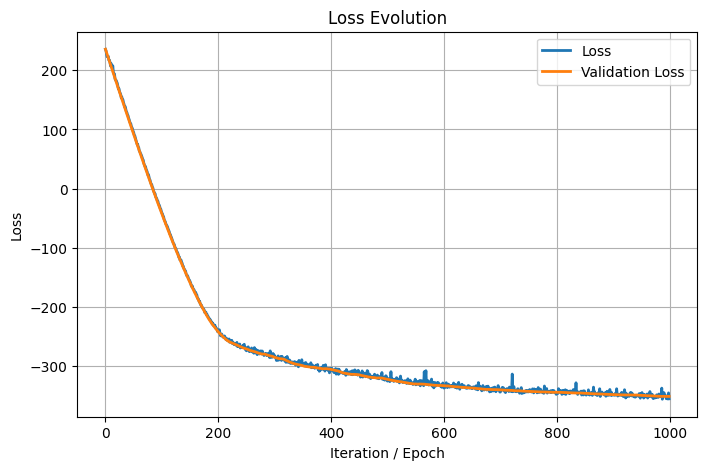

In [10]:
import matplotlib.pyplot as plt
loss_history = output['loss_history']
val_loss = output['val_history']


# Plot            
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label="Loss", linewidth=2)
plt.plot(val_loss, label="Validation Loss", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
print(len(output['mu']), sum(p.numel() for p in model.parameters() if p.requires_grad))
print(output['mu'])

150 150
tensor([-9.1651e+00,  1.2579e+00,  1.5134e+00,  1.3274e+00,  1.5187e+00,
         1.7088e+00,  4.2446e-01,  6.9080e-01,  9.6751e-01,  1.3499e+00,
         1.4953e+00,  1.5648e+00, -8.6185e+00,  9.1837e-01,  1.2507e+00,
         1.0550e+00,  1.0704e+00,  1.4399e+00,  9.3450e-02, -1.6802e-01,
         1.6482e+00,  2.4733e+00,  2.7579e+00,  2.7748e+00, -2.9394e-02,
        -2.8011e-03,  2.5241e-02, -4.4007e-02,  5.2507e-03,  1.0548e-02,
        -3.9747e-02, -7.0677e-02, -1.9230e-01, -2.8190e-01, -3.7467e-01,
        -2.2250e-01,  9.2116e-02,  2.9735e-01,  3.8589e-01,  1.4137e-01,
         7.3078e-02, -6.5272e-02,  5.4984e-02, -1.4564e-01, -7.2589e-01,
         1.0250e+00,  5.4139e-01,  2.9714e-01,  4.0170e-01,  4.8785e-01,
         1.4702e-01,  2.0872e-01,  4.5407e-02,  1.8506e-01,  1.4608e-01,
        -2.5797e-02, -7.6540e-02,  1.4954e-01,  3.4946e-01, -1.7299e-01,
        -6.2133e-03,  2.4357e-01,  2.6168e-01,  1.5929e-01,  4.8829e-02,
         7.7400e-02, -6.4950e-03,  8.2568e-

In [12]:
import torch

def flat_params(model):
    return torch.cat([p.detach().flatten().cpu() for p in model.parameters()])

# snapshot BEFORE
before = flat_params(model).clone()

model.bayesian_param_set(output, update_buffers=False)
# snapshot AFTER
after = flat_params(model)

max_abs_change = (after - before).abs().max().item()
print(f"Max |Δ| across all parameters: {max_abs_change:.3e}")



Max |Δ| across all parameters: 0.000e+00


In [13]:
# pretrain the marginal transformations
#_ = model.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

In [14]:
# train the joint model
#_ = model.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
#                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
#                max_batches_per_iter=False)

### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [15]:
log_likelihood_train_gtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model.log_likelihood(simulated_data_test)

In [16]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [17]:
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )

print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD GTM      Train Data:  1.6046
KLD Gaussian Train Data:  0.1038
KLD Copula   Train Data:  -0.0002
KLD GTM      Test  Data:  1.5985
KLD Gaussian Test  Data:  0.1073
KLD Copula   Test  Data:  0.0004


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [18]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)

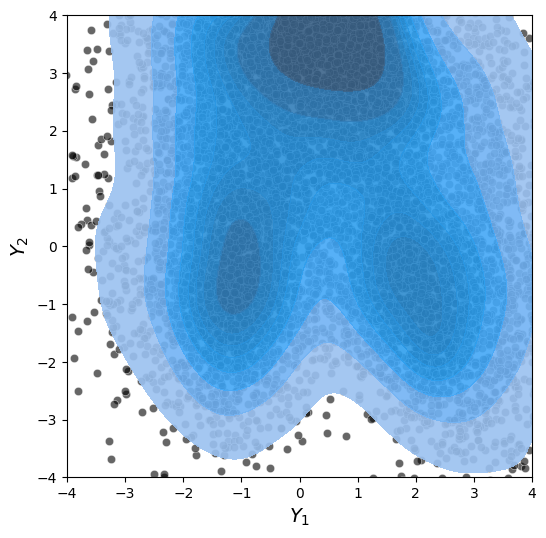

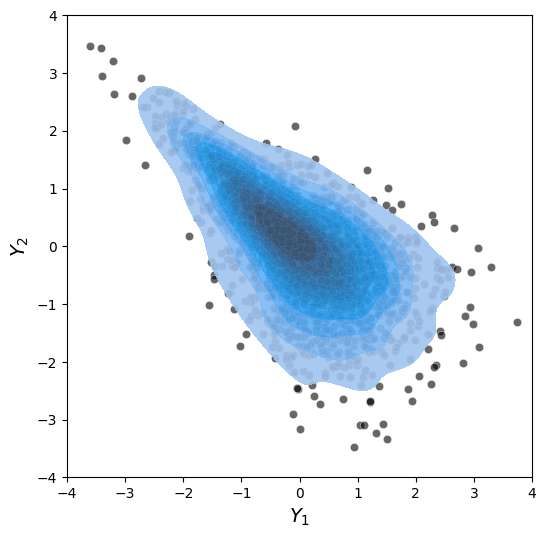

In [19]:
model.plot_densities(synthetic_samples, x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

In [20]:
pseudo_conditional_correlation_matrix = model.compute_pseudo_conditional_correlation_matrix(synthetic_samples)

/Users/franciscocapunay/miniforge3/envs/gtm-magic-env-3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/franciscocapunay/miniforge3/envs/gtm-magic-env-3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


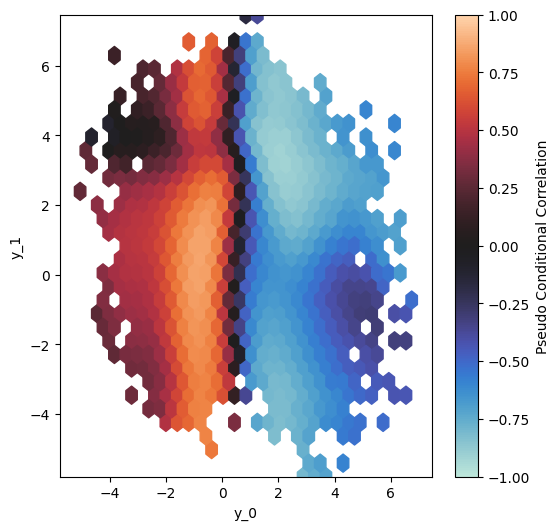

In [21]:
model.plot_conditional_dependence_structure(data=synthetic_samples)

One can also visualize the splines of each layer usign the function `plot_splines`. For the transformation layer we additionally include the dervaitive which is always positive due to the monotonically increasing constraint as well as the inverse which should lie exactly on the spline to visually confirm that the inverse sampling path works.

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


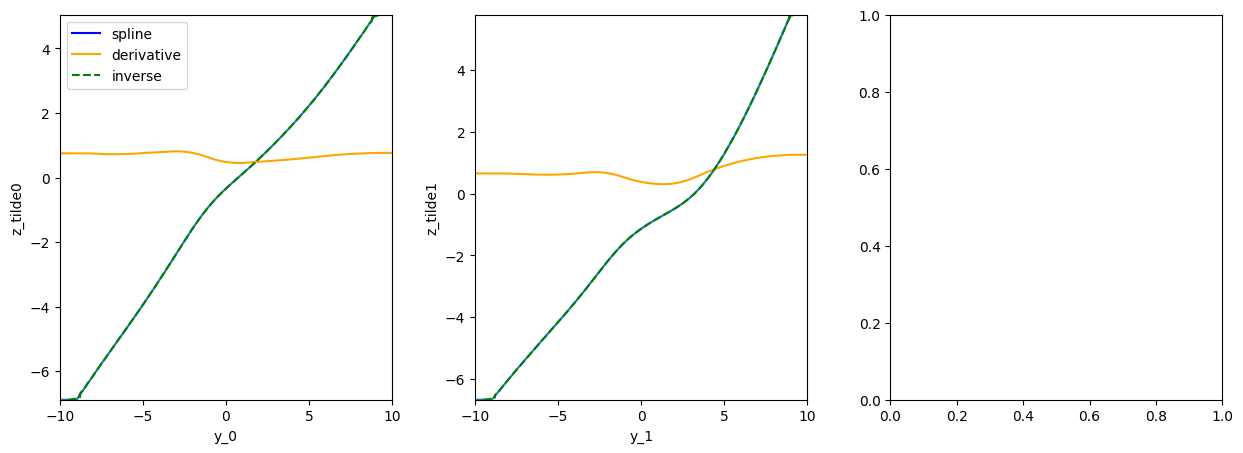

In [22]:
model.plot_splines(layer_type="transformation")

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


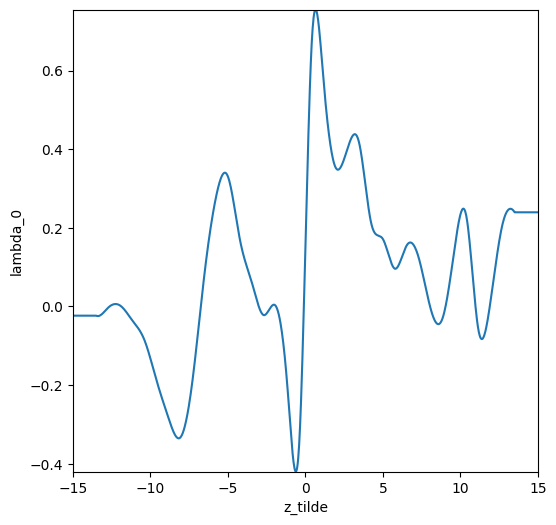

In [23]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


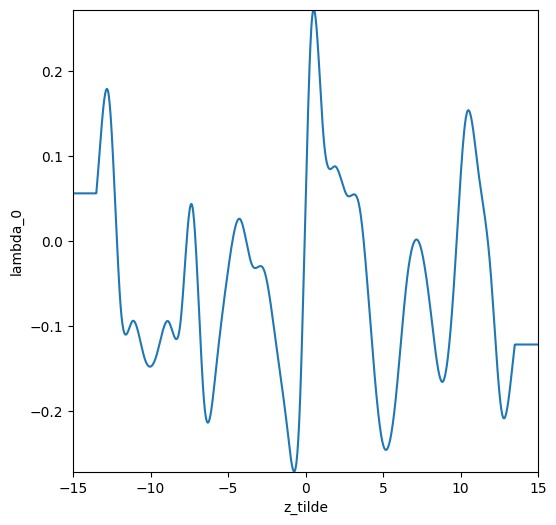

In [24]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


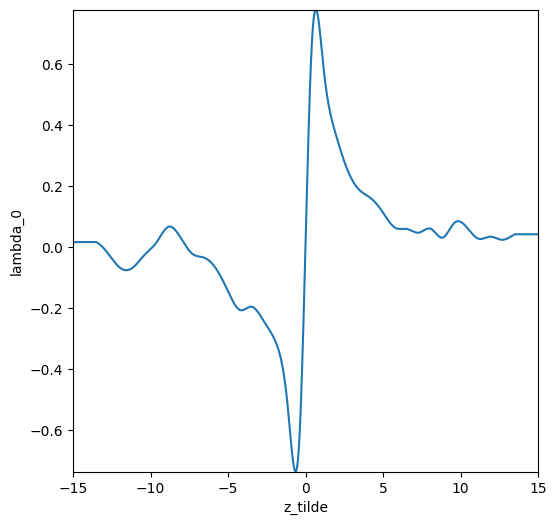

In [25]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)